# Imports

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns

# Data

## Load

In [8]:
# Set paths
dataPath = '/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_2_processed_data/'

# Load data
df = pd.read_csv(dataPath + 'all_subject_measure_data.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_20642/3261809689.py:5: DtypeWarning: Columns (2040) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataPath + 'all_subject_measure_data.csv')


## Reshape

In [64]:
# Common columns for joining
common_cols = ['cohort', 'onOff', 'ParticipantIdentifier']

# SUCCESS
# Feature Columns
selected_cols = [col for col in df.columns if col.startswith('ib_domain_success_')]

# Combine and select columns
df_temp = df[common_cols + selected_cols]

# Reshape
df_long_success = pd.melt(df_temp, id_vars=common_cols, value_vars=selected_cols,
                  var_name='category',
                  value_name='success'
                  )

# Remove the extra detail about category
df_long_success['category'] = df_long_success['category'].str.replace('^ib_domain_success_', '', regex=True)

# Rename category values to avoid spaces
replace_dict={
    'Community involvement': 'Community_involvement',
    'Self-Improvement': 'Self_Improvement',
    'Video games': 'Video_games'
}

df_long_success['category'] = df_long_success['category'].replace(replace_dict)

print(np.unique(df_long_success.category))
df_long_success.sample(10)

['Admin' 'Alcohol_drug' 'Community_involvement' 'Cooking' 'Culture' 'Diet'
 'Environment' 'Exercise' 'Family' 'Finances' 'Friends' 'Future_Planning'
 'Hobby' 'Housework' 'Learning' 'Medical_Health' 'MentalPersonal_Health'
 'Online' 'Other' 'Partner' 'Personal_Values' 'Phone' 'Punctuality'
 'Reading_leisure' 'Self_Improvement' 'Sleep' 'SocialMedia' 'Social_life'
 'Sports_playing' 'TV_Streaming' 'Time_Management' 'Video_games'
 'Volunteering' 'Work_School']


cohort        onOff                 ParticipantIdentifier  \
10193  cohort 1  offBoarding  d99872af-3068-4840-9118-3e5724df83b8   
2051   cohort 1   onBoarding  596d1036-bafa-47c3-9886-a588a37789bb   
8787   cohort 2   onBoarding  739d41bb-f3ec-4860-be5a-c711aaec4729   
1921   cohort 2   onBoarding  739f2417-2416-4646-b108-e73bb870d326   
6574   cohort 1  offBoarding  852b45ca-f506-42b2-b5bd-2b0072b1b28b   
3090   cohort 1          NaN  fa996c7b-fd1c-4cba-990a-336f4cefaeb4   
9636   cohort 2  offBoarding  077803ce-0421-40c5-846d-40f0a9ac6a83   
859    cohort 2  offBoarding  98f7c7df-3bbf-44bf-99be-e2995f557e91   
4948   cohort 1  offBoarding  a9de00be-460d-4b74-bed3-bf013fe2052a   
10087  cohort 2   onBoarding  63f4637d-9f05-4561-8995-667470be3c7c   

                    category  success  
10193            Punctuality      NaN  
2051                  Online     18.0  
8787   Community_involvement      NaN  
1921            Alcohol_drug      NaN  
6574             Work_School      NaN  
3090         Reading_leisure      NaN  
9636                Finances      NaN  
859    MentalPersonal_Health     52.0  
4948                 Partner      NaN  
10087        Time_Management     42.0

In [73]:
# IMPORTANCE
# Feature Columns
selected_cols = [col for col in df.columns if col.startswith('ib_domain_import_')]

# Combine and select columns
df_temp = df[common_cols + selected_cols]

# Reshape
df_long_import = pd.melt(df_temp, id_vars=common_cols, value_vars=selected_cols,
                  var_name='category',
                  value_name='import'
                  )

# Remove the extra detail about category
df_long_import['category'] = df_long_import['category'].str.replace('^ib_domain_import_', '', regex=True)

In [74]:
# EFFORT
# Feature Columns
selected_cols = [col for col in df.columns if col.startswith('ib_domain_effort_')]

# Combine and select columns
df_temp = df[common_cols + selected_cols]

# Reshape
df_long_effort = pd.melt(df_temp, id_vars=common_cols, value_vars=selected_cols,
                  var_name='category',
                  value_name='effort'
                  )

# Remove the extra detail about category
df_long_effort['category'] = df_long_effort['category'].str.replace('^ib_domain_effort_', '', regex=True)

### Join

In [66]:
df_long = df_long_success
df_long['import'] = df_long_import['import']
df_long['effort'] = df_long_effort['effort']
df_long['time'] = df_long_time['time']

df_long.sample(10)

cohort        onOff                 ParticipantIdentifier  \
4909  cohort 1  offBoarding  147400db-43d9-4155-8bf2-b85b8adf4315   
1842  cohort 2  offBoarding  9f0105f6-8198-4bee-8717-7df0d8903e76   
4103  cohort 2  offBoarding  4f4440e7-3a38-4fa7-9271-9730806e441a   
1113  cohort 1   onBoarding  f889f1a4-9754-456e-ae08-092f992d3359   
9725  cohort 2   onBoarding  08e76051-ee6e-4872-896f-4ed3857afc0f   
709   cohort 1  offBoarding  d973b82f-367b-4871-94a9-181421f870e8   
551   cohort 2  offBoarding  e3ace276-145e-49a3-8ca1-43e4ab34f2e5   
7600  cohort 1   onBoarding  39d785c6-9e3d-44c2-88ec-2ce14ef923f9   
2467  cohort 2  offBoarding  4e465685-8d64-4b22-8b6c-9409f9eb3c02   
7881  cohort 1  offBoarding  837ea159-60c6-4bde-b3ba-2c107844a9bb   

                   category  success  import  effort  time  
4909                Partner      NaN     NaN     NaN   NaN  
1842           Alcohol_drug      NaN     NaN     NaN   NaN  
4103           TV_Streaming      NaN     NaN     NaN   NaN  
1113         Medical_Health      NaN     NaN     NaN   NaN  
9725               Finances     19.0     6.0     5.0   4.0  
709   MentalPersonal_Health     51.0     7.0     7.0   7.0  
551                Exercise      NaN     NaN     NaN   NaN  
7600               Learning     12.0     3.0     1.0   1.0  
2467                  Phone      NaN     NaN     NaN   NaN  
7881       Self_Improvement      NaN     NaN     NaN   NaN

## Add Moderators and Outcomes

In [ ]:
moderators = [
    'con_hex_score',
    'social_des_score',
    'ambition_score',
    'brief_self_control_score',
    'bsss_overall',
    'future_time_perspective_score',
    'grit_scale_score',
    'secular_measure_work_ethic_score'
]

outcomes = [
    'flourishing_score',
    'harmony_score',
    'qol_score',
    'sat_life_score',
    'sub_happy_score',
    'DASS_overall',
    'perceived_stress_score',
    'rosenberg_SES_score'
]

df_mo = df[moderators + outcomes]

In [72]:
df_long.loc[(df_long['ParticipantIdentifier'] == '0151d9f1-1644-4437-805e-02f5e244a690') & (df_long['onOff'] == 'offBoarding') & (df_long['category'] == 'Hobby')]

cohort        onOff                 ParticipantIdentifier category  \
5708  cohort 2  offBoarding  0151d9f1-1644-4437-805e-02f5e244a690    Hobby   

      success  import  effort  time  
5708     43.0     2.0     3.0   3.0

In [6]:
len(np.unique(df.loc[(df.onOff == 'onBoarding') & (df.cohor),:].ParticipantIdentifier))

AttributeError: 'DataFrame' object has no attribute 'coh'

In [39]:
df.head()

ParticipantIdentifier        onOff        category  success  \
0  0151d9f1-1644-4437-805e-02f5e244a690  offBoarding            Diet       82   
1  0151d9f1-1644-4437-805e-02f5e244a690  offBoarding        Exercise       90   
2  0151d9f1-1644-4437-805e-02f5e244a690  offBoarding  MentalPersonal       75   
3  0151d9f1-1644-4437-805e-02f5e244a690  offBoarding           Sleep       68   
4  0151d9f1-1644-4437-805e-02f5e244a690  offBoarding           Hobby       43   

   time  import  effort  flourishing_score  harmony_score  qol_score  ...  \
0   3.0       5     4.0                5.5            3.0     4.6875  ...   
1   3.0       6     5.0                5.5            3.0     4.6875  ...   
2   3.0       5     4.0                5.5            3.0     4.6875  ...   
3   4.0       6     2.0                5.5            3.0     4.6875  ...   
4   3.0       2     3.0                5.5            3.0     4.6875  ...   

   future_time_perspective_score  grit_scale_score  need_for_cognition_score  \
0                            5.5               3.5                  3.354839   
1                            5.5               3.5                  3.354839   
2                            5.5               3.5                  3.354839   
3                            5.5               3.5                  3.354839   
4                            5.5               3.5                  3.354839   

   trait_hedonic_capacity_score  domain_gap  model1_gap  successXimport  \
0                           3.7   24.083333   32.868684             410   
1                           3.7   24.083333   27.452038             540   
2                           3.7   24.083333   39.868684             375   
3                           3.7   24.083333   42.749070             408   
4                           3.7   24.083333   69.633828              86   

   successXtime  successXeffort  model2_gap  
0         246.0           328.0   67.181510  
1         270.0           450.0   98.049326  
2         225.0           300.0   55.759361  
3         272.0           136.0   46.864532  
4         129.0           129.0   12.969173  

[5 rows x 32 columns]

<Axes: >

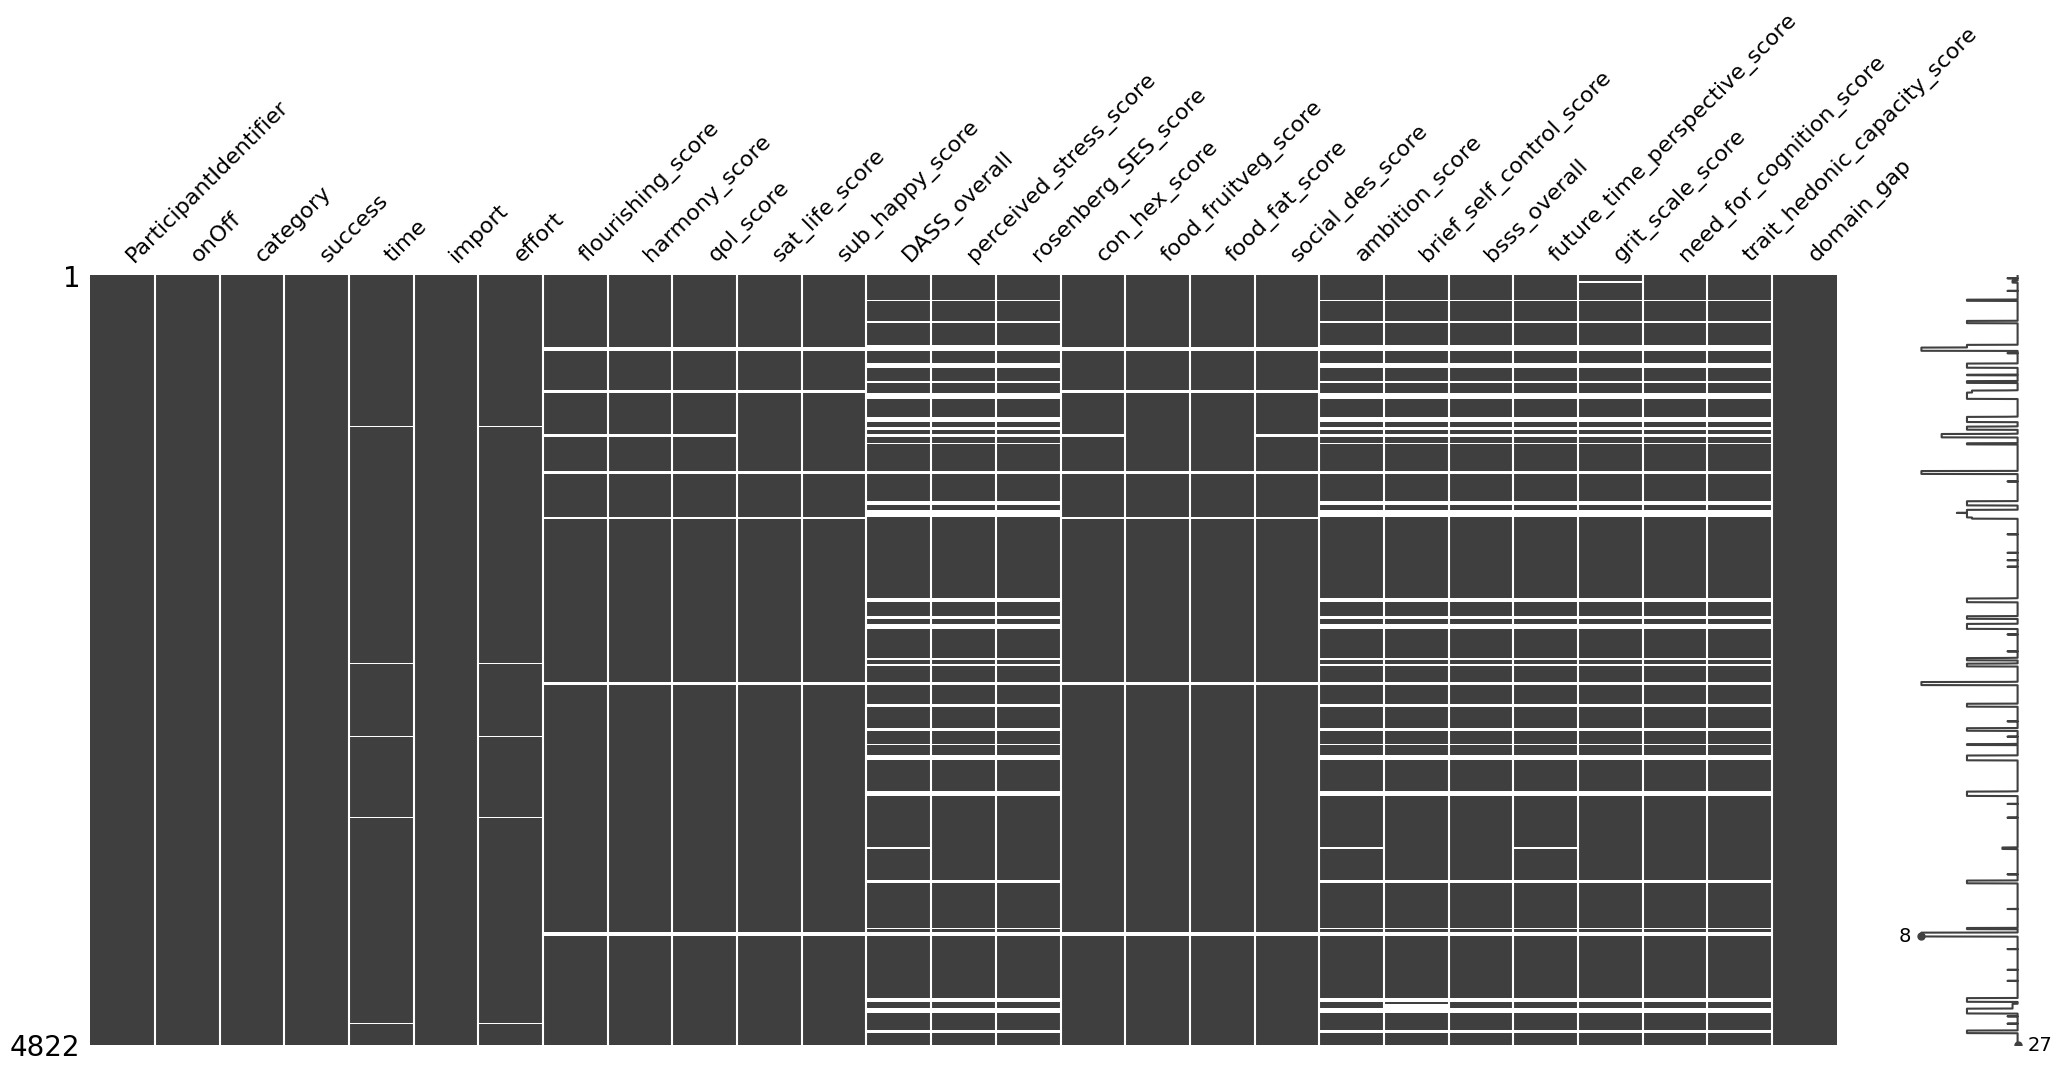

In [8]:
msno.matrix(df)

## Select

In [9]:
# Specify outcome columns
outcomes = ['flourishing_score',
            'harmony_score',
            'qol_score',
            'sat_life_score',
            'sub_happy_score',
            'DASS_overall',
            'perceived_stress_score',
            'rosenberg_SES_score']

# Create df for selected outcome
outcome = 0
df_temp = df[['success', 'time', 'import', 'effort', outcomes[outcome]]]

# Reverse score negative outcomes
df.perceived_stress_score = 6 - df.perceived_stress_score
df.DASS_overall = 3 - df.DASS_overall

# Remove rows with na values
df_temp = df_temp.dropna()

# Separate features and target
features = ['success', 'time', 'import', 'effort']
X = df_temp[features]
y = df_temp[outcomes[0]]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Look at data

# Models

## 1 | Base

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_3_data_analysis/python_analysis/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Cross-validated Mean Squared Error: 1.2129454644552848
Test Mean Squared Error: 1.170704473449432


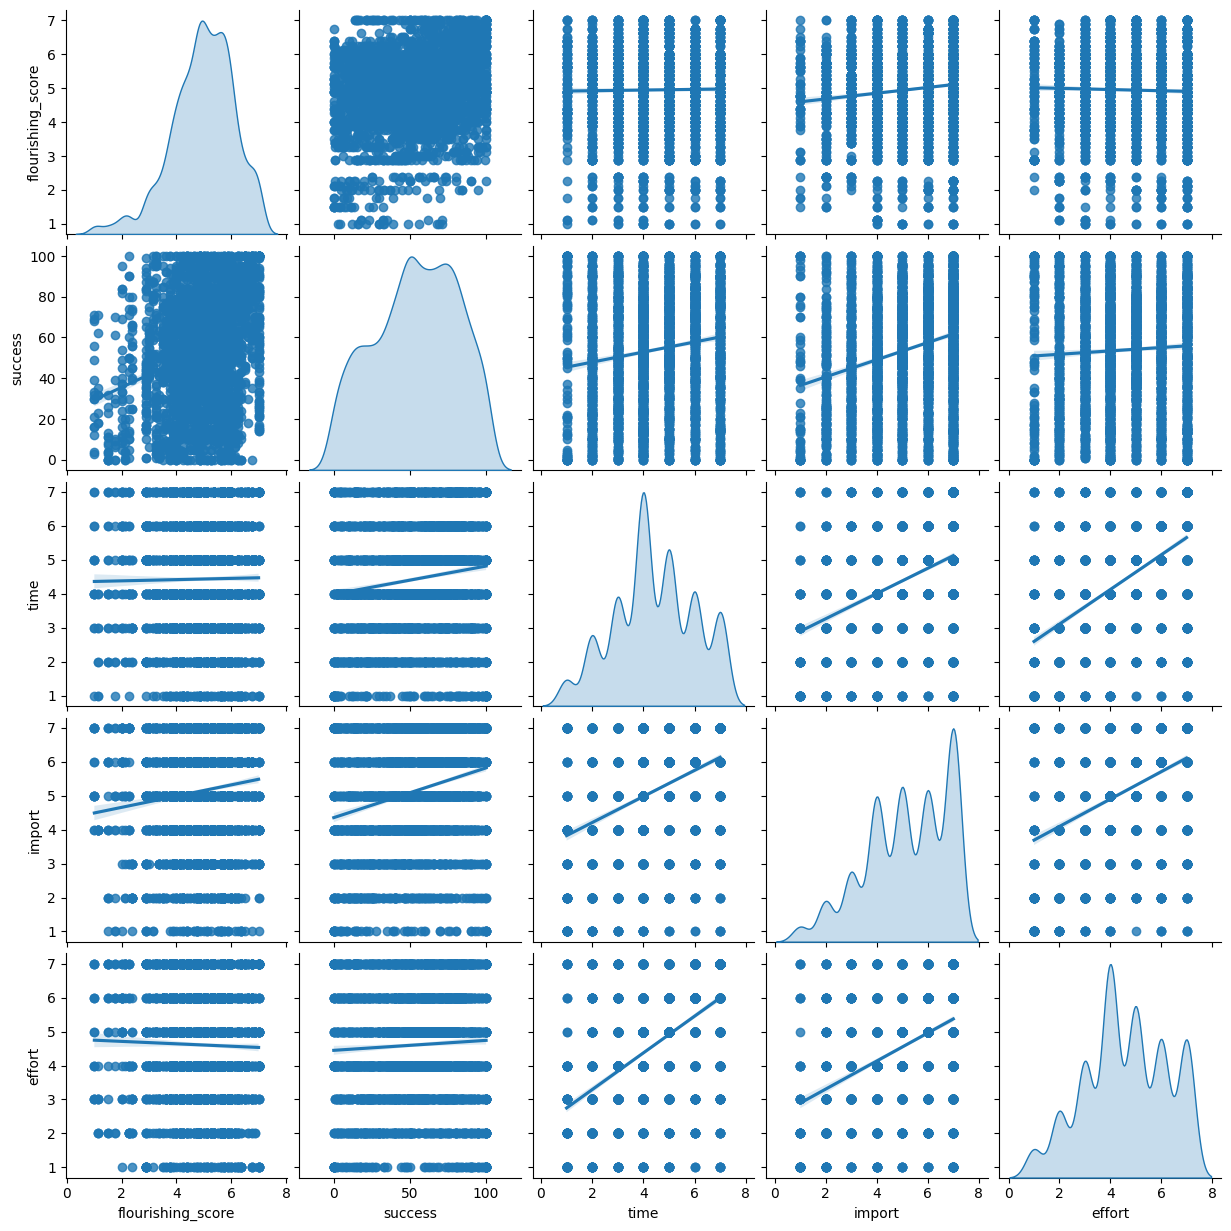

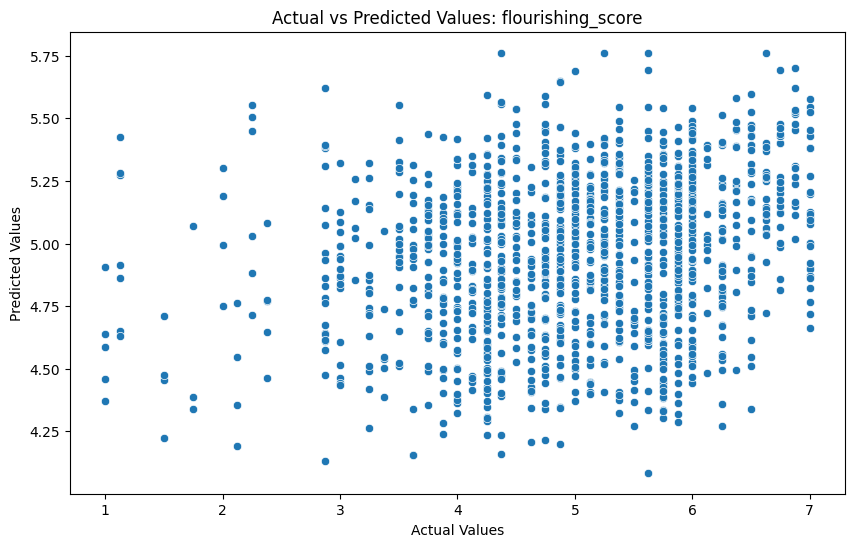

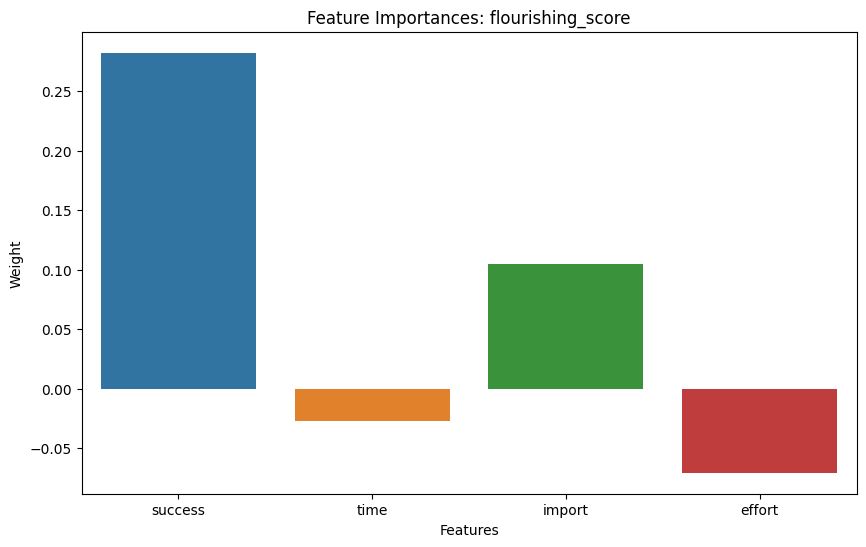

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_3_data_analysis/python_analysis/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Cross-validated Mean Squared Error: 1.6043284686807198
Test Mean Squared Error: 1.5022243422322488


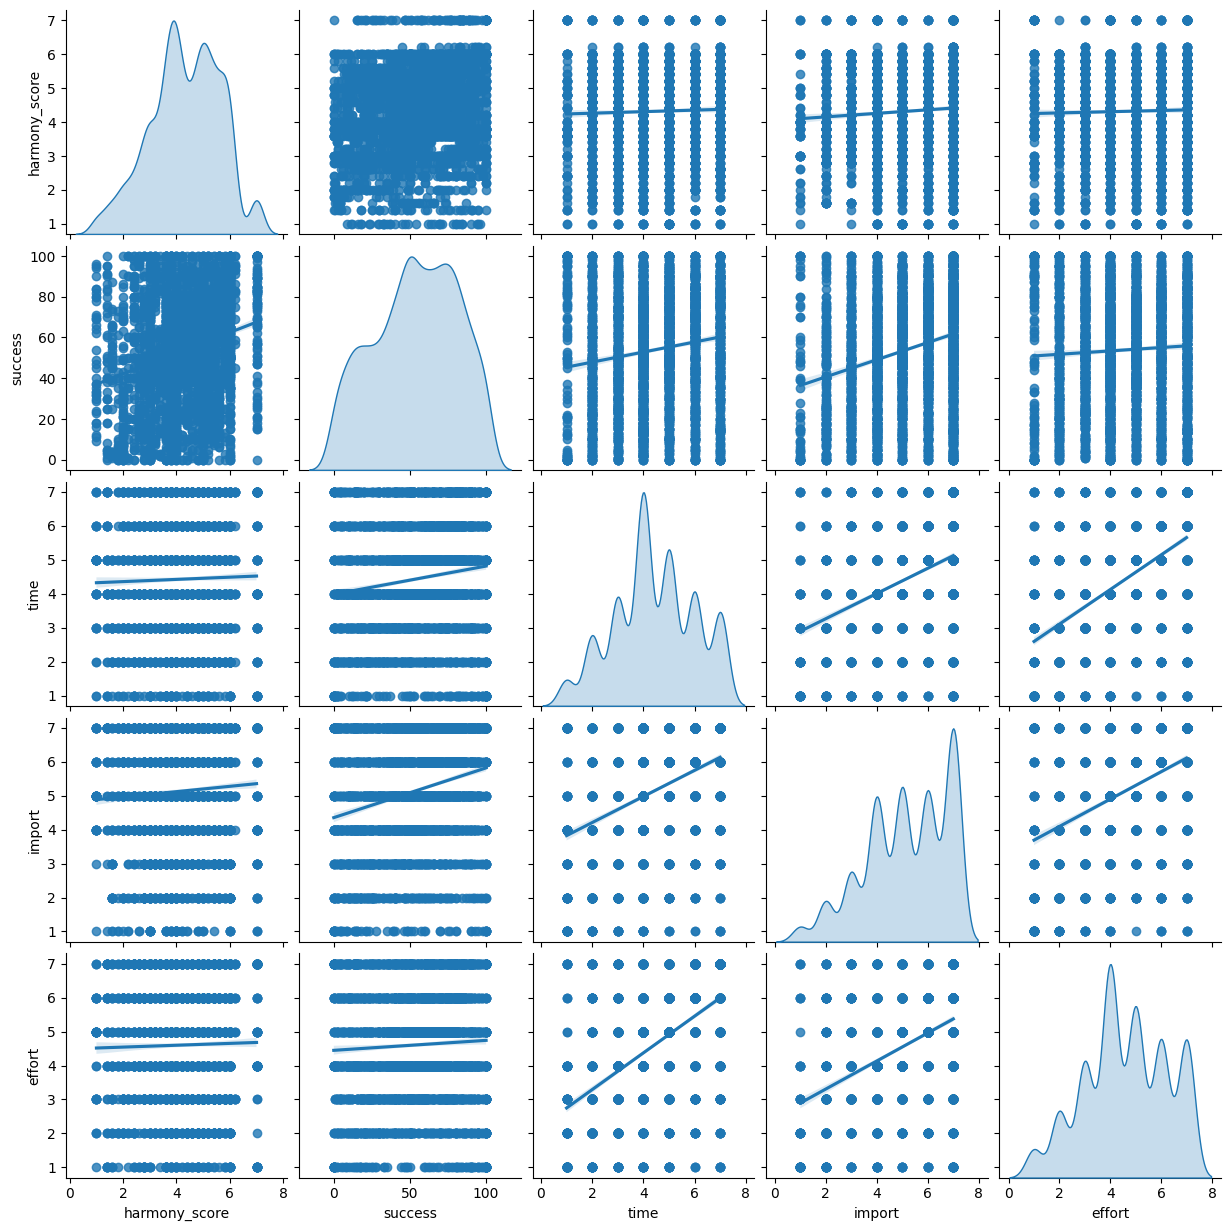

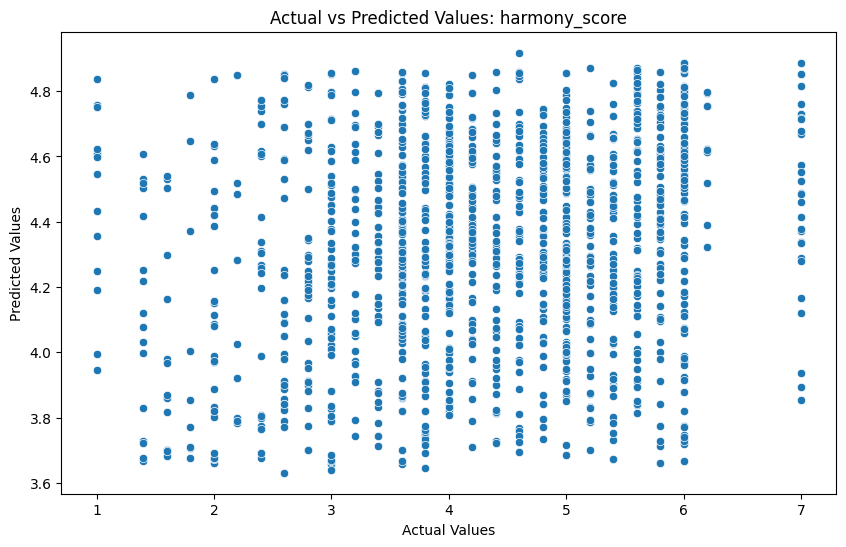

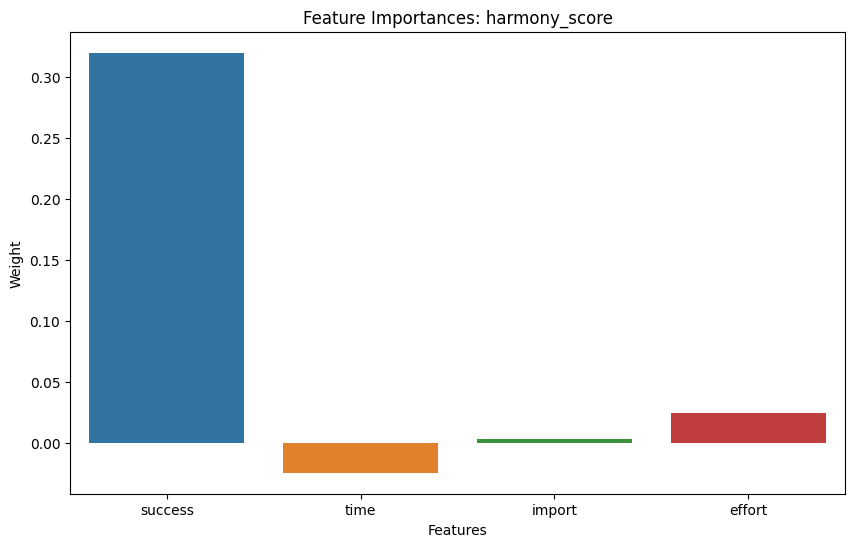

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_3_data_analysis/python_analysis/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Cross-validated Mean Squared Error: 0.8050229590150547
Test Mean Squared Error: 0.757350315693306


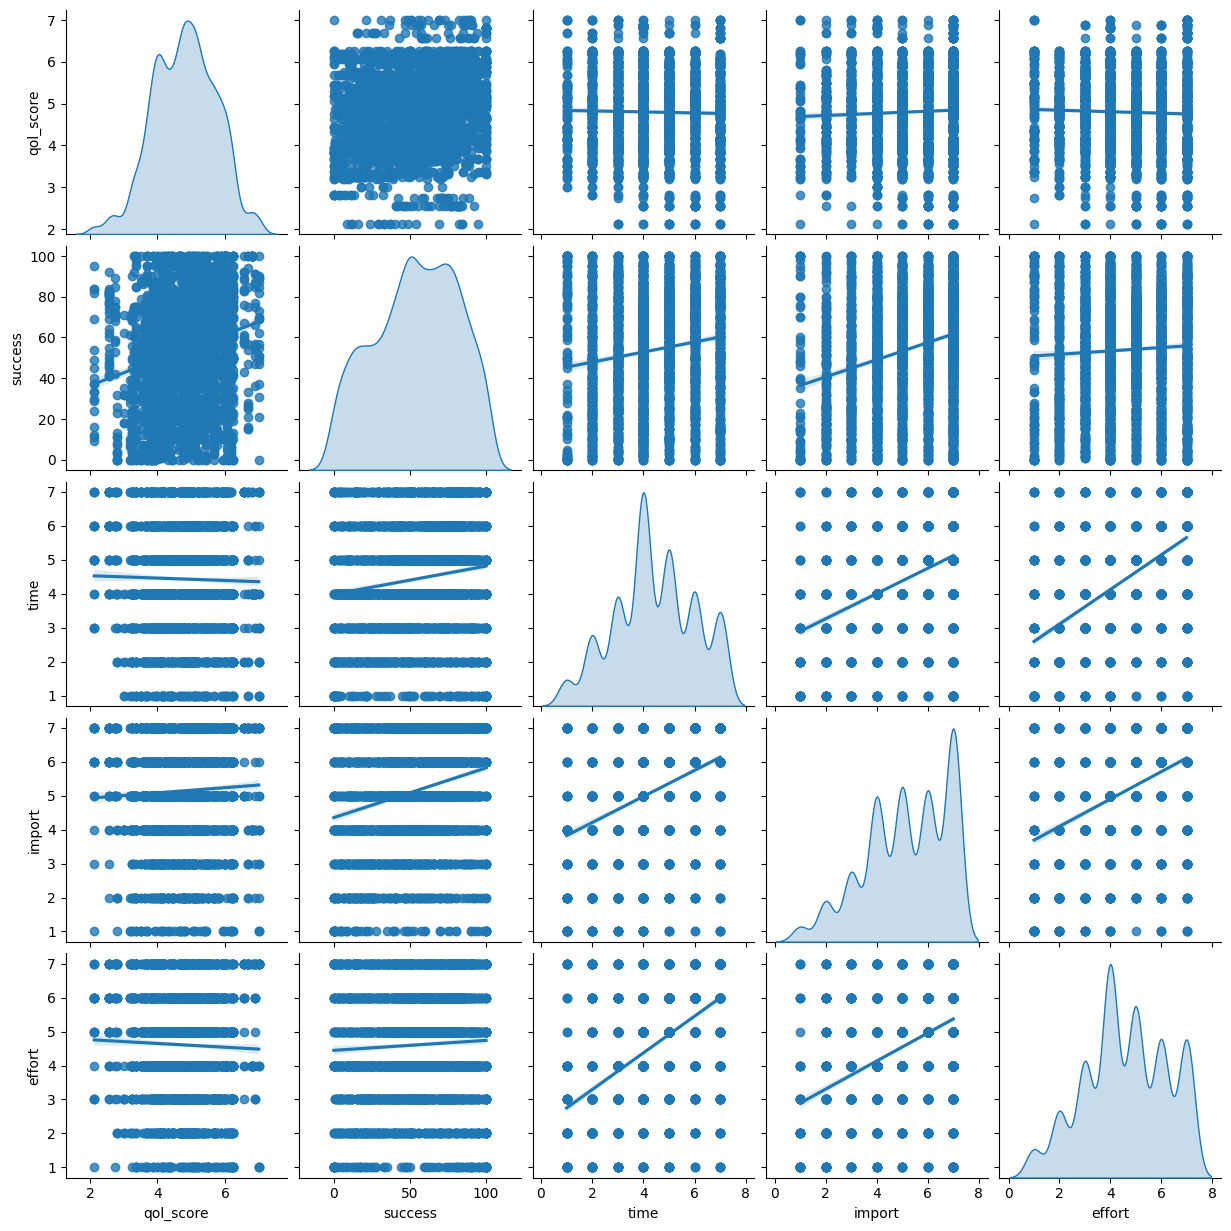

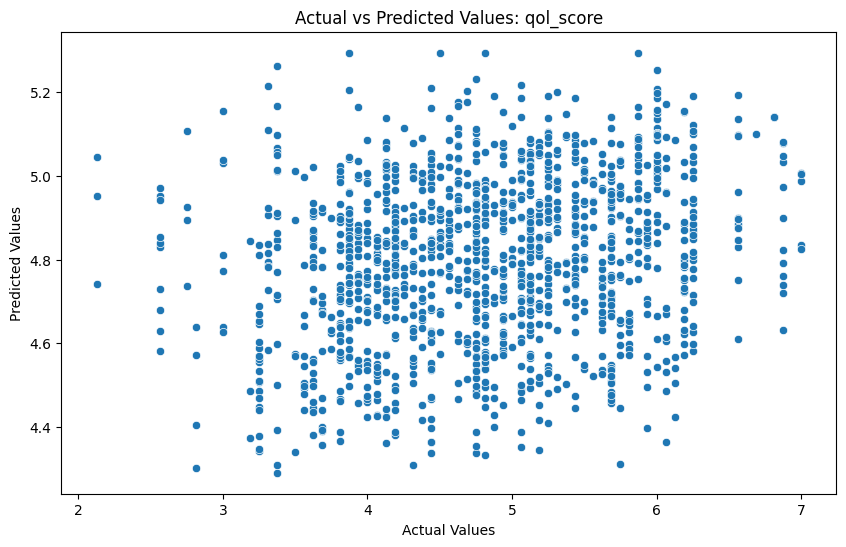

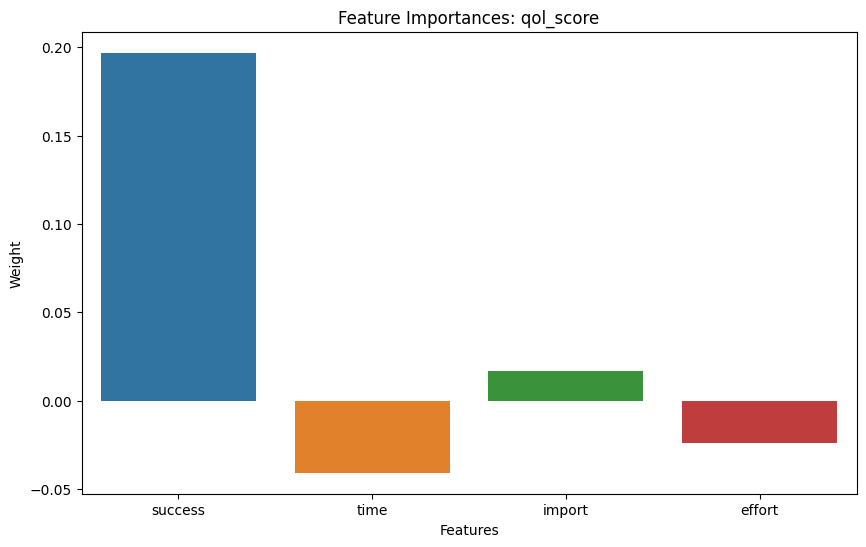

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_3_data_analysis/python_analysis/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Cross-validated Mean Squared Error: 1.8717428513679557
Test Mean Squared Error: 1.8872363191496893


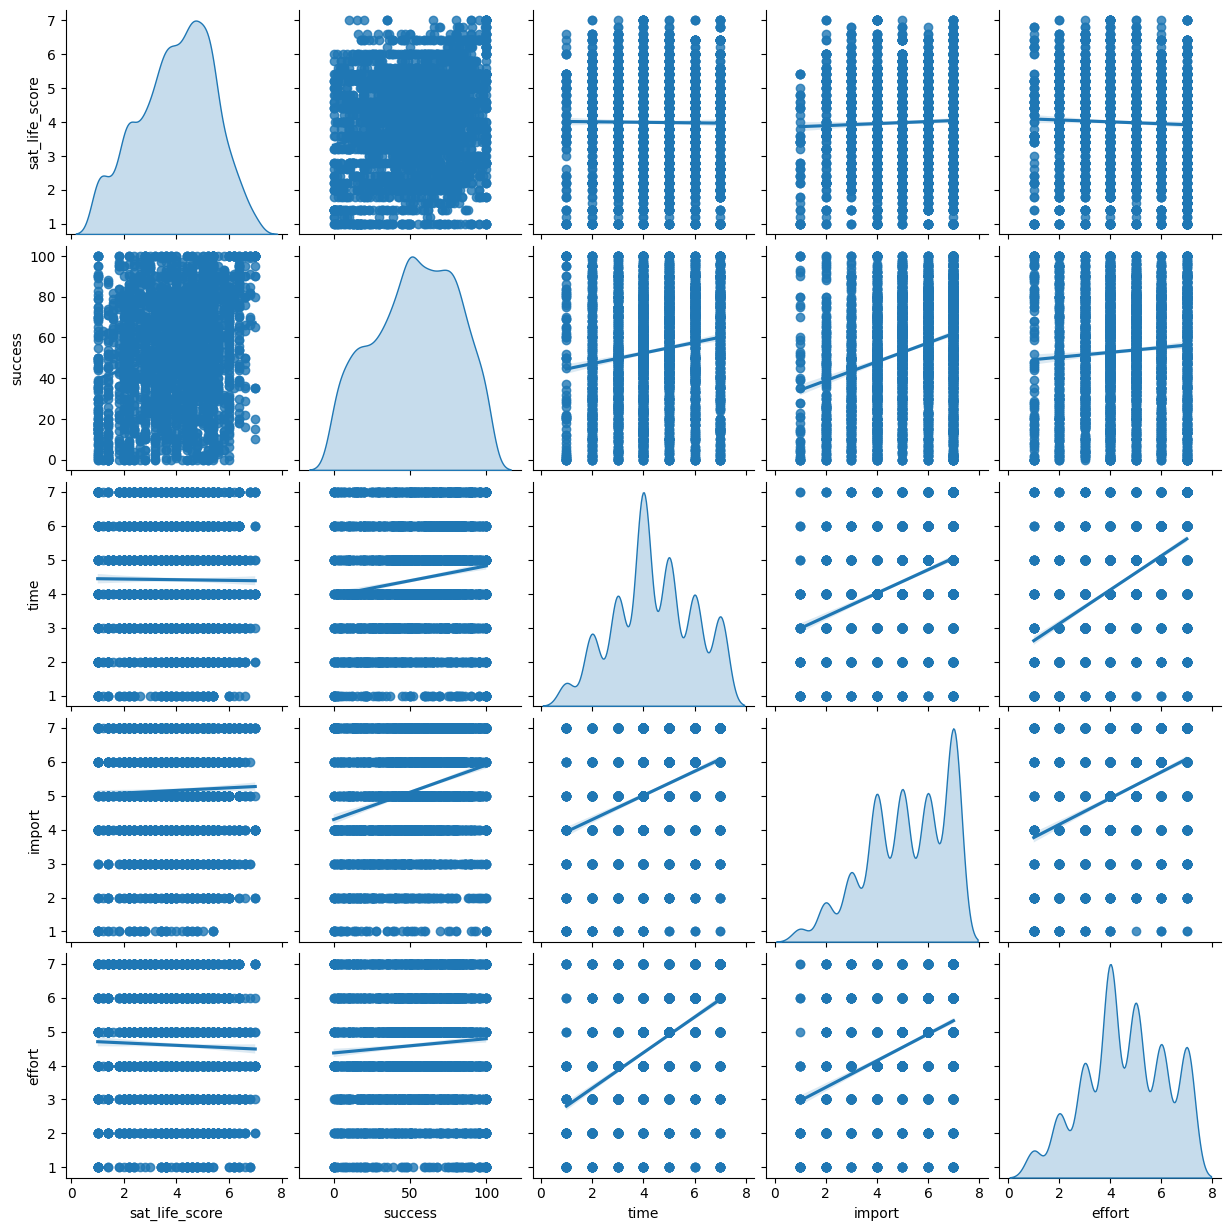

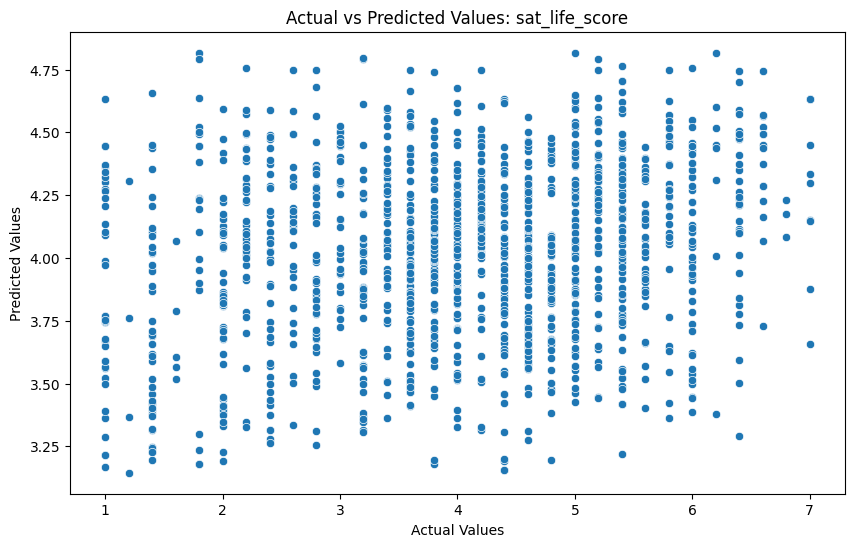

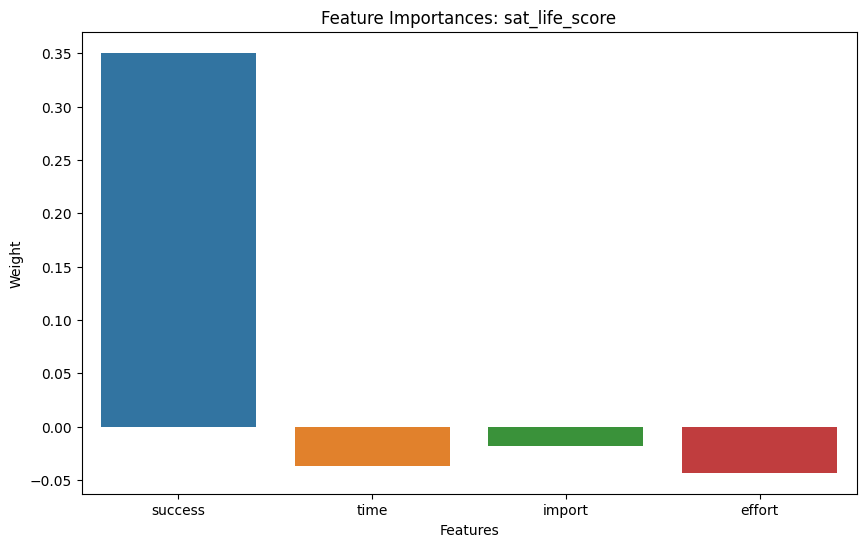

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_3_data_analysis/python_analysis/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Cross-validated Mean Squared Error: 1.4852105451472677
Test Mean Squared Error: 1.5479428031020066


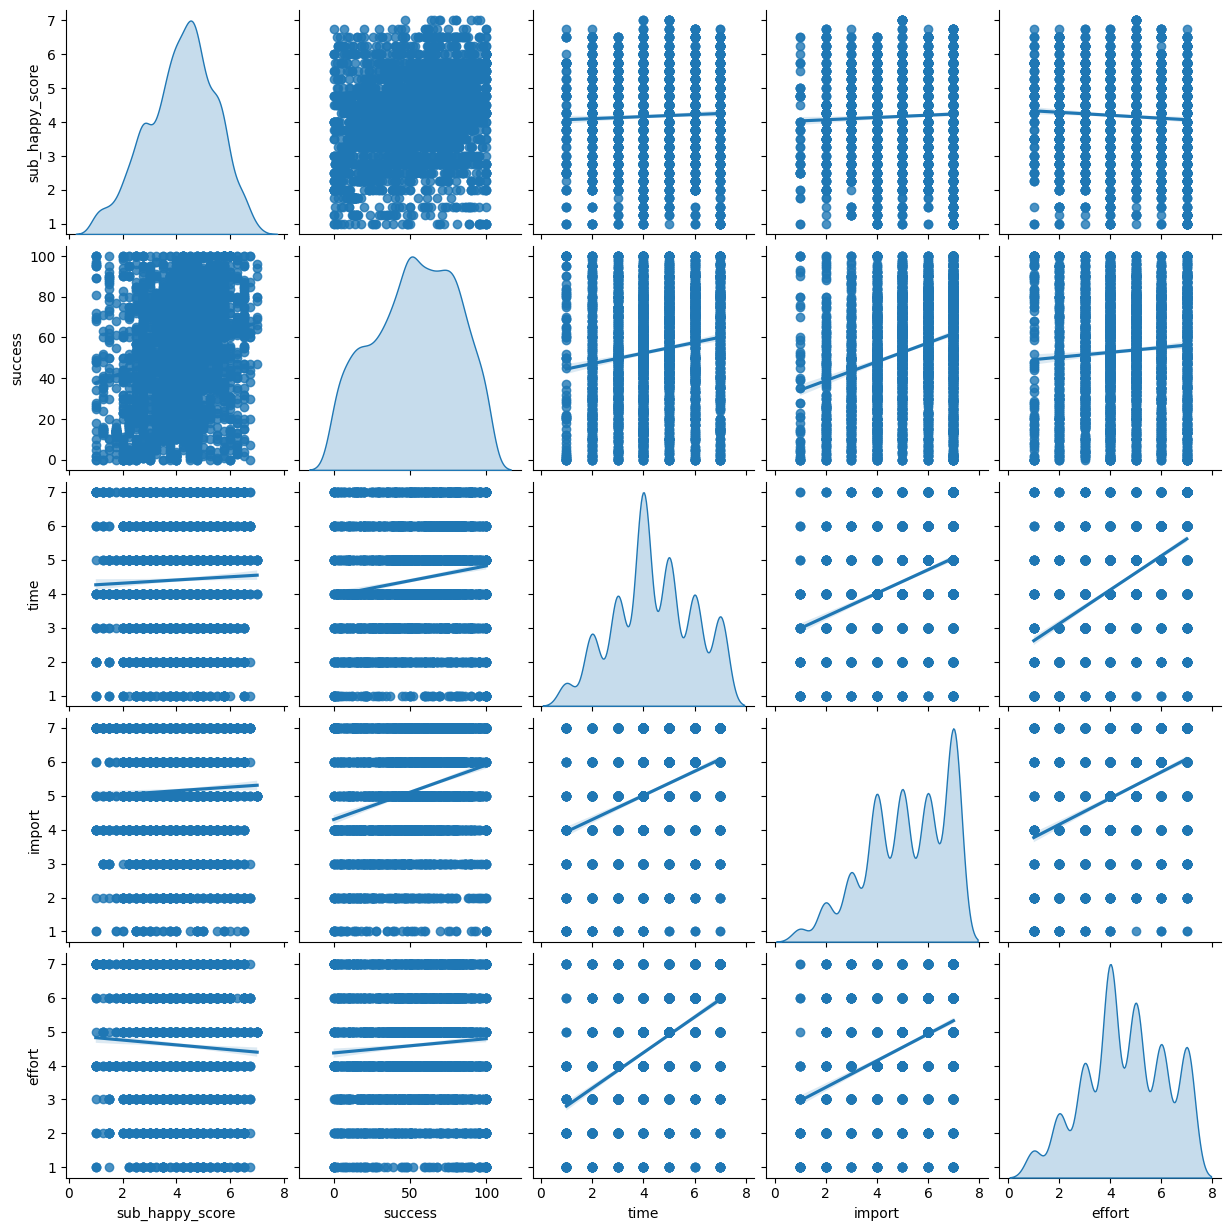

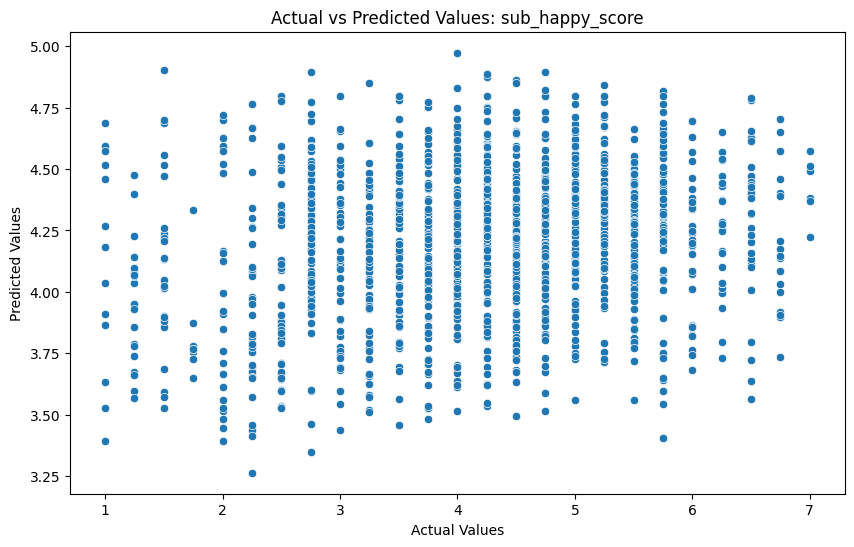

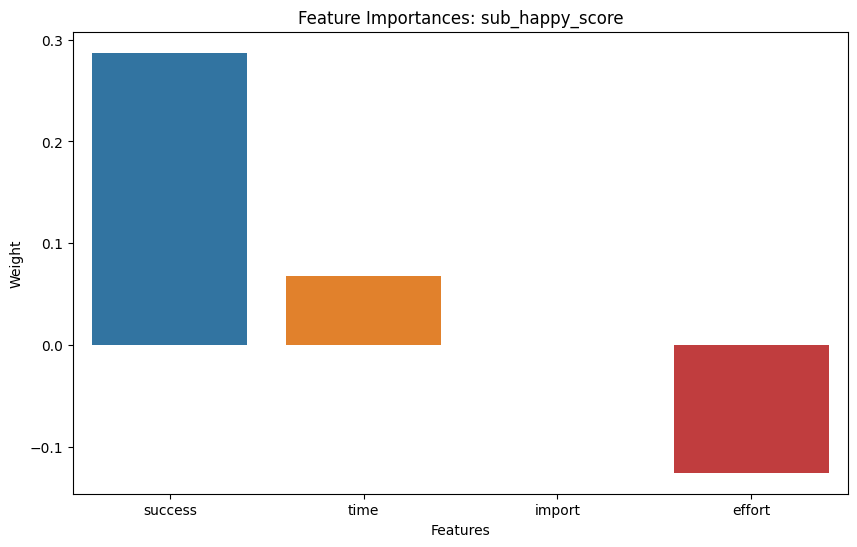

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_3_data_analysis/python_analysis/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Cross-validated Mean Squared Error: 0.33047239355377167
Test Mean Squared Error: 0.33707465673083814


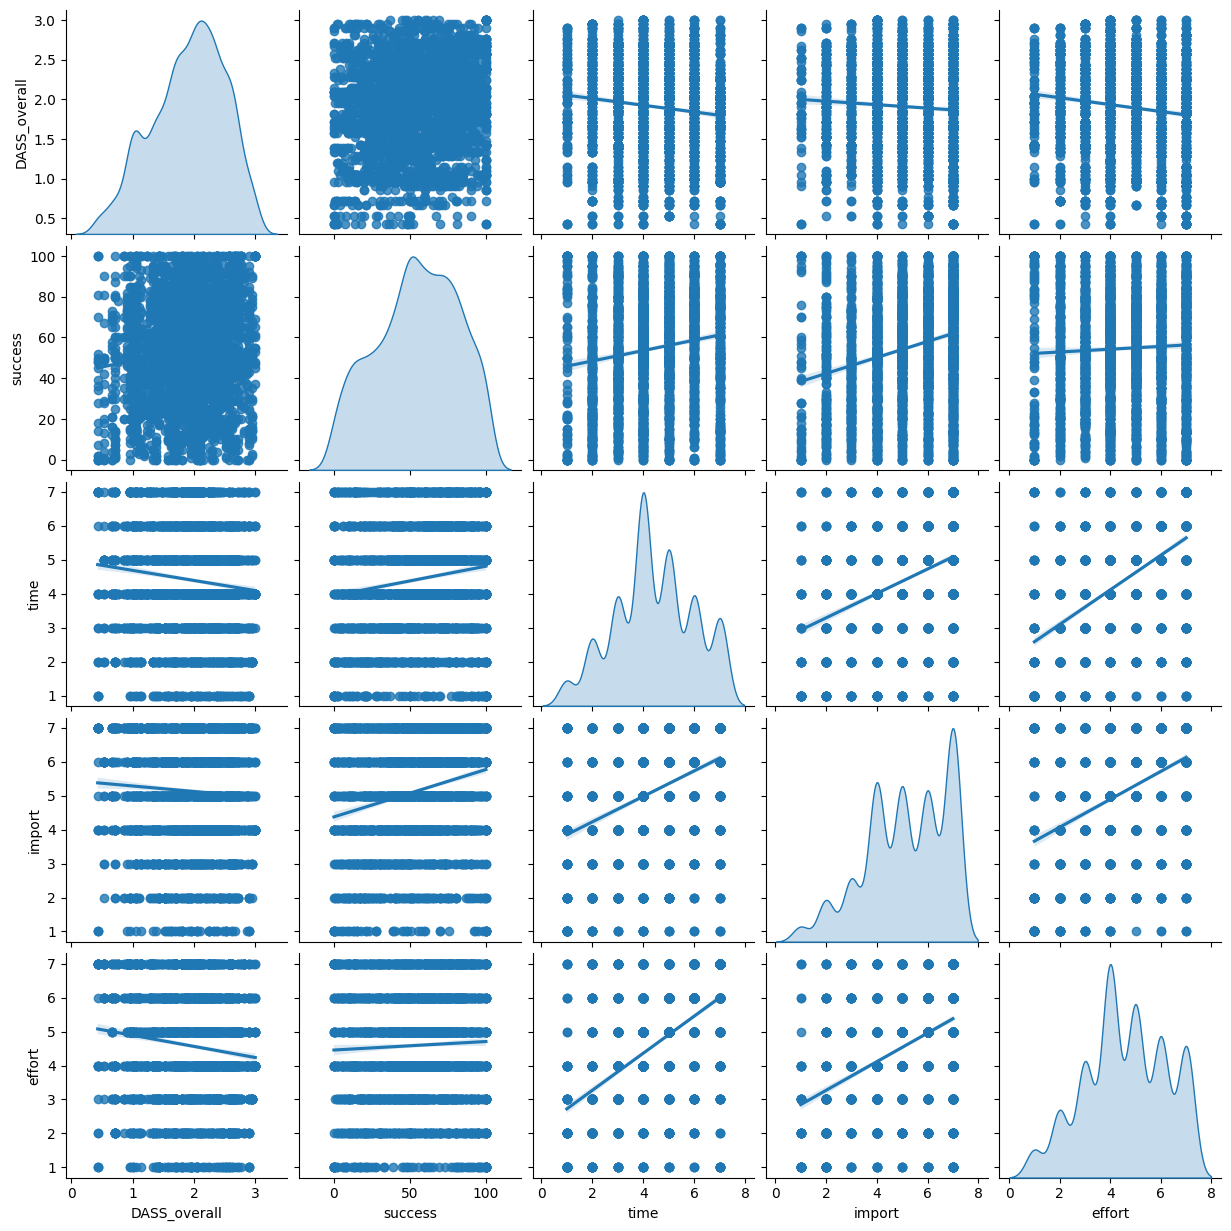

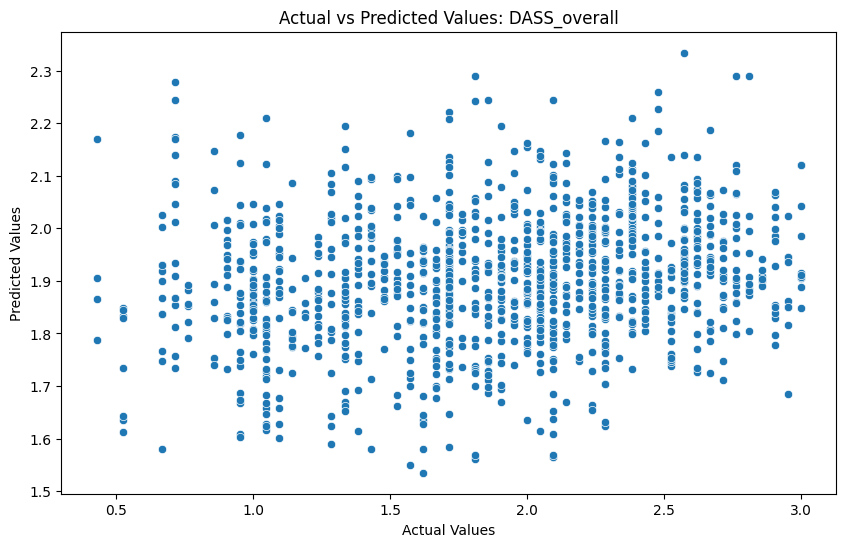

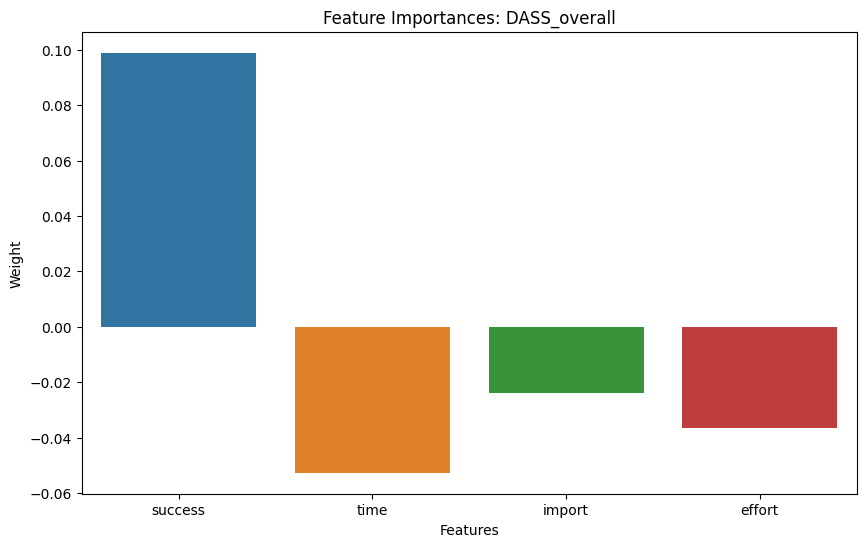

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_3_data_analysis/python_analysis/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Cross-validated Mean Squared Error: 0.36428662373862153
Test Mean Squared Error: 0.3353434402666577


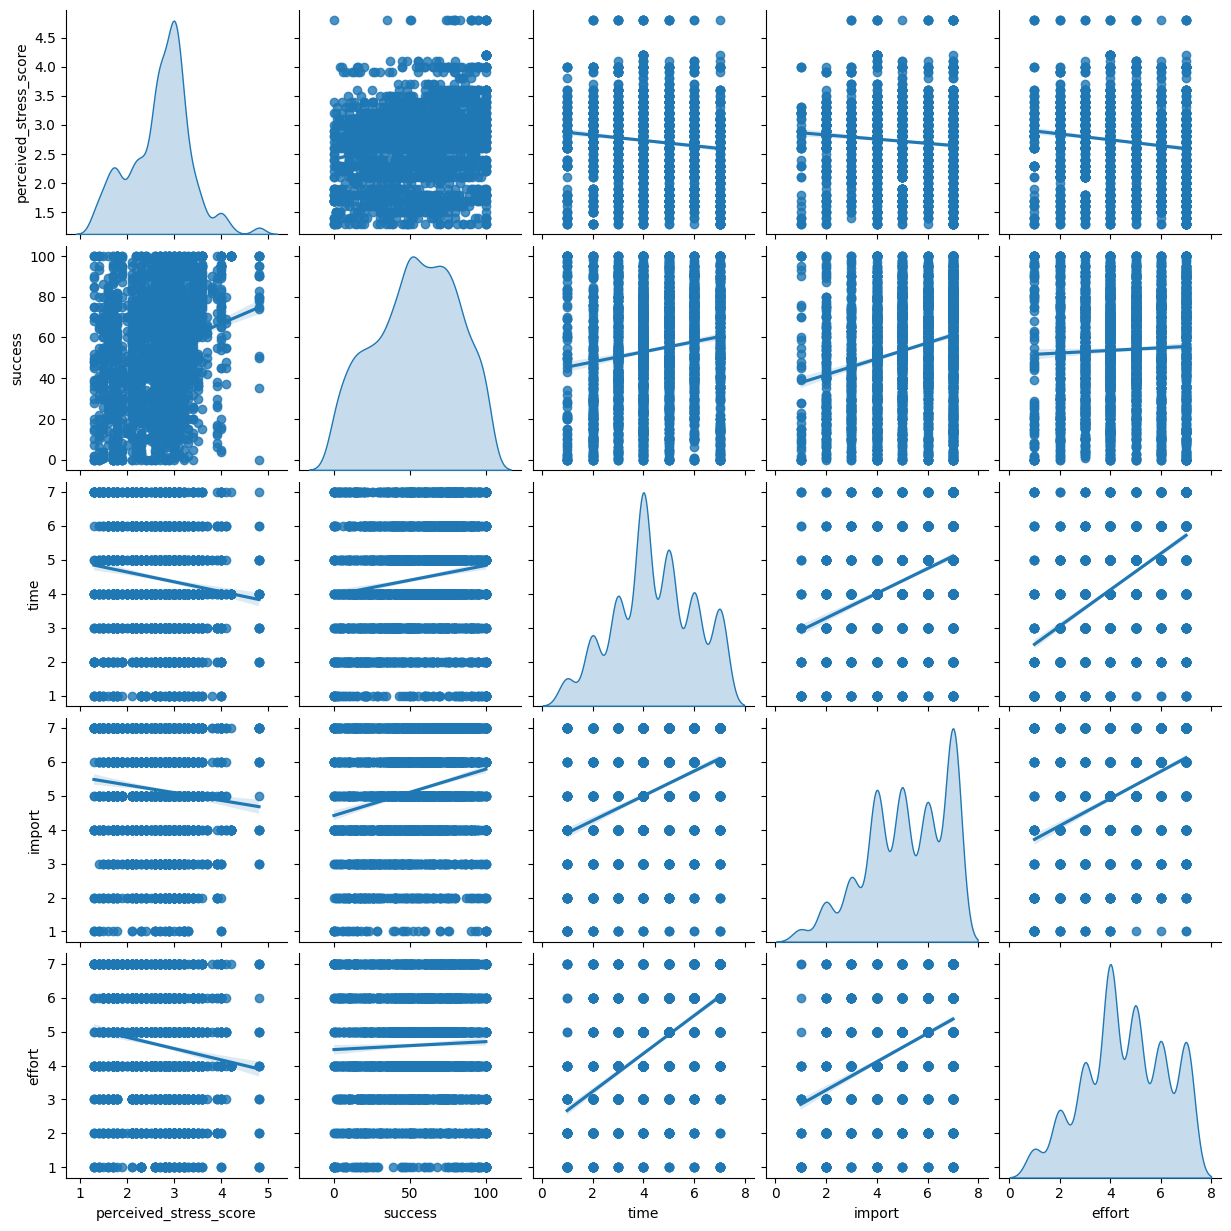

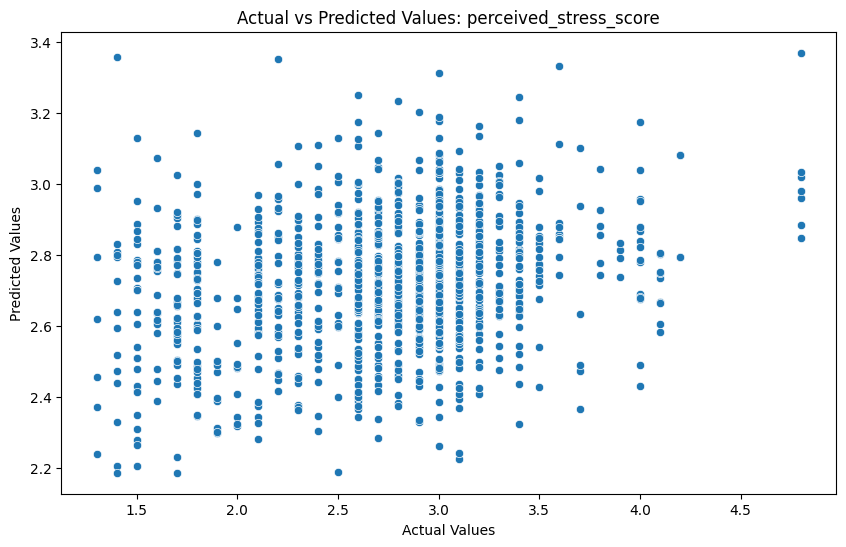

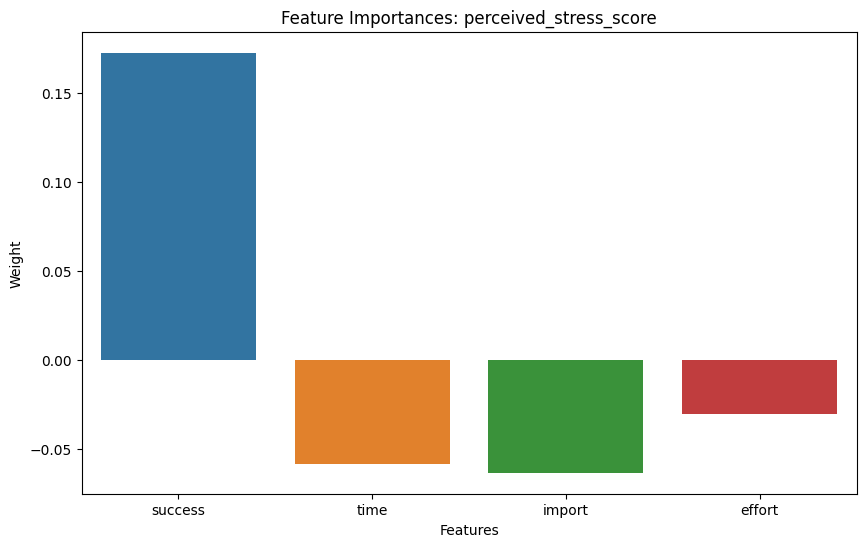

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_3_data_analysis/python_analysis/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Cross-validated Mean Squared Error: 0.307472398923535
Test Mean Squared Error: 0.28742440274164


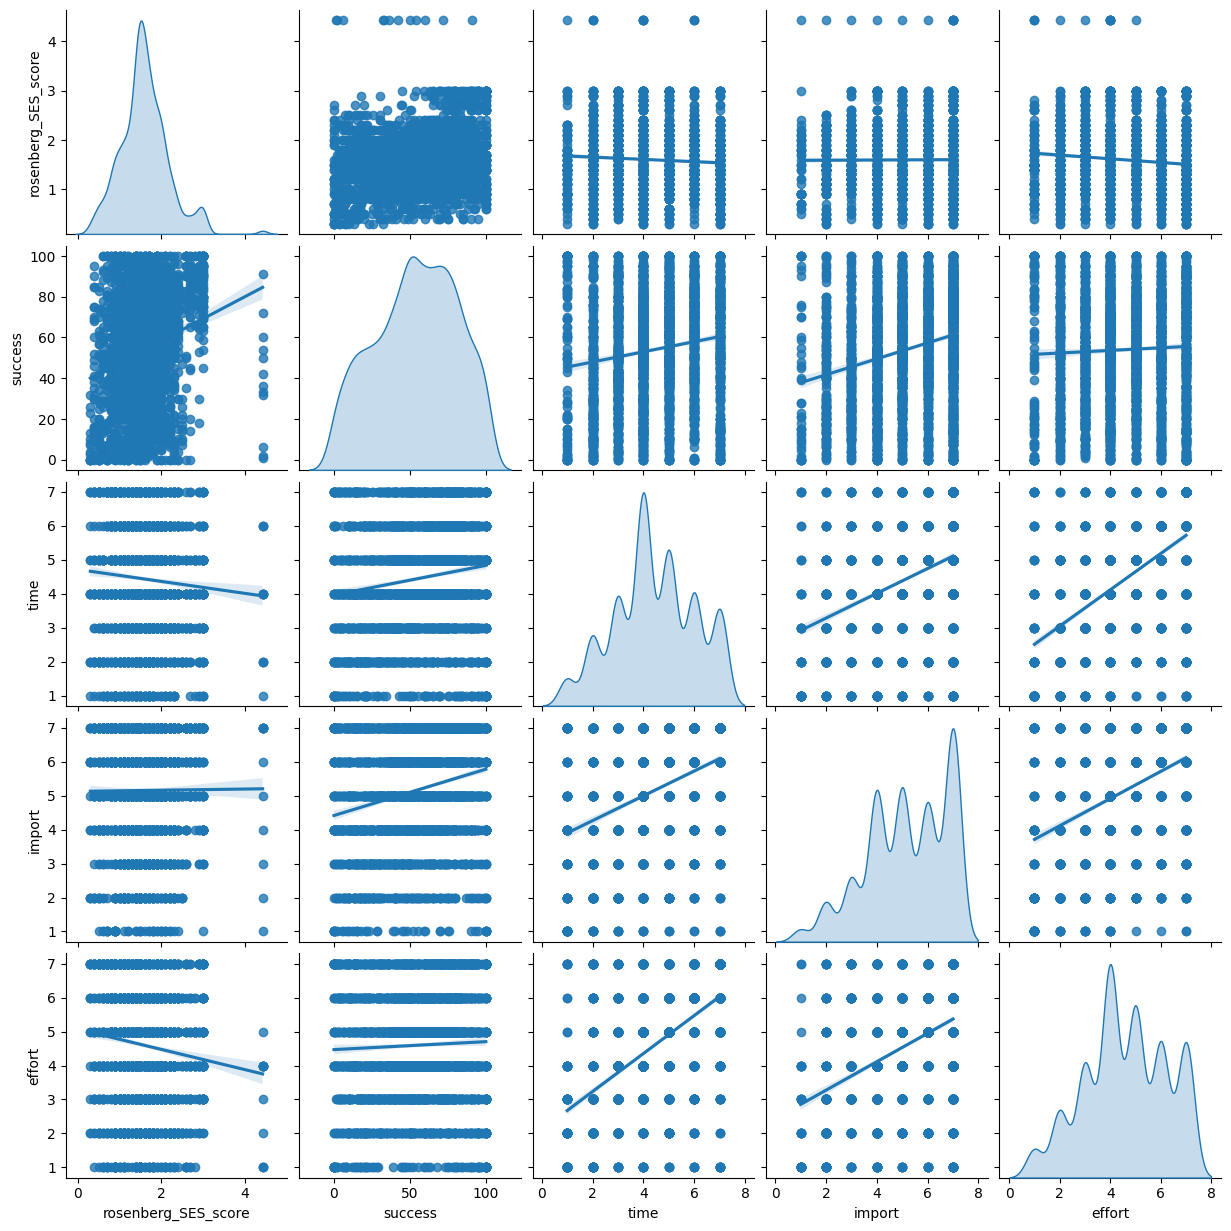

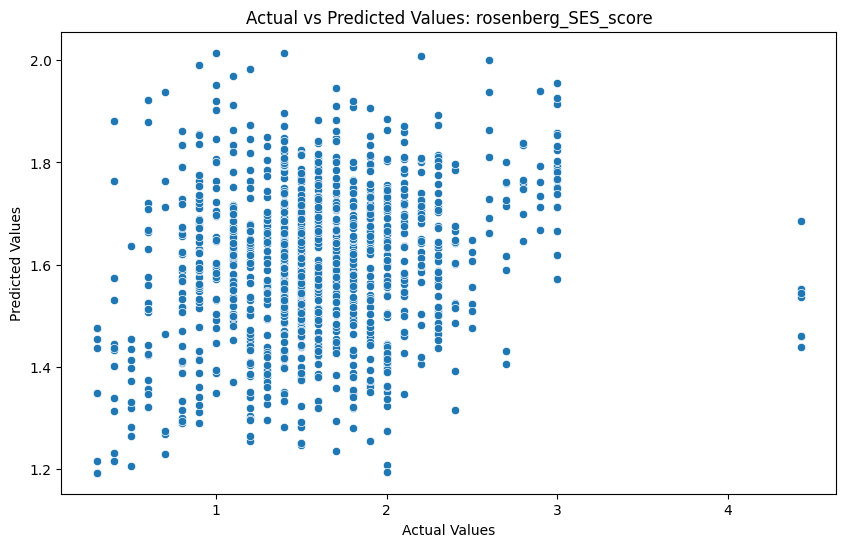

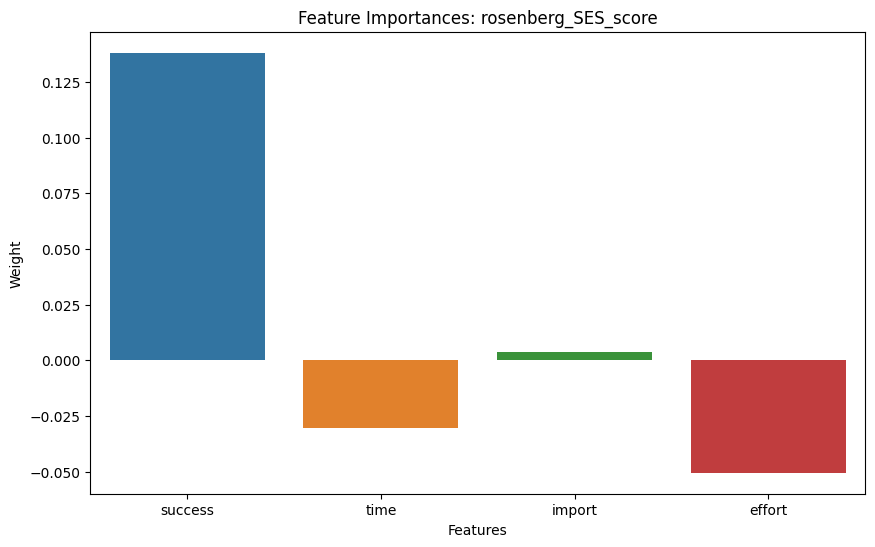

In [10]:
# Create an empty DataFrame with these column names
column_names = ['outcome'] + features + ['train_error', 'test_error'] + ['data_version']
df_coefs = pd.DataFrame(np.empty((len(outcomes), len(column_names))),columns=column_names)

# which data are we using?
data_version = 'Base - 4 dimensions'

for outcome in outcomes:
    # select df
    df_temp = df[['success', 'time', 'import', 'effort', outcome]]

    # Remove rows with na values
    df_temp = df_temp.dropna()

    # Separate features and target
    features = ['success', 'time', 'import', 'effort']
    X = df_temp[features]
    y = df_temp[outcome]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # # Look at data
    # train_dataset = X_train.copy()
    # train_dataset.insert(0, outcome, y_train)
    # _ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

    # Define a pipeline. We standardize the data first, then apply linear regression
    pipeline = make_pipeline(StandardScaler(), LinearRegression())

    # Define a cross-validation strategy
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    # Use the cross_val_score function to perform cross-validation
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

    # Print the mean of the cross-validation scores
    print(f'Cross-validated Mean Squared Error: {-cv_results.mean()}')

    # Fit and evaluate the pipeline
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Test Mean Squared Error: {mse}')

    ## Update dataframe
    # get current index
    ix = outcomes.index(outcome)

    # name outcome
    df_coefs.loc[ix, 'outcome'] = outcome

    # add data source
    df_coefs.loc[ix, 'data_version'] = data_version
    
    # Add coefs
    model_coefs = pipeline.named_steps['linearregression'].coef_
    df_coefs.loc[ix, features] = model_coefs

    # Add errors
    df_coefs.loc[ix, 'train_error'] = -cv_results.mean()
    df_coefs.loc[ix, 'test_error'] = mse

#    coefs.append(pipeline.named_steps['linearregression'].coef_)

    # # Plot actual vs predicted values
    # plt.figure(figsize=(10, 6))
    # sns.scatterplot(x=y_test, y=y_pred)
    # plt.xlabel('Actual Values')
    # plt.ylabel('Predicted Values')
    # plt.title('Actual vs Predicted Values: ' + outcome)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=features, y=pipeline.named_steps['linearregression'].coef_)
    plt.xlabel('Features')
    plt.ylabel('Weight')
    plt.title('Feature Importances: ' + outcome)
    plt.show()

### Coefficients

In [11]:
df_coefs

outcome   success      time    import    effort  \
0       flourishing_score  0.282205 -0.027685  0.104396 -0.070745   
1           harmony_score  0.319808 -0.024369  0.003033  0.024463   
2               qol_score  0.196931 -0.040752  0.016979 -0.024135   
3          sat_life_score  0.350465 -0.036704 -0.018199 -0.043128   
4         sub_happy_score  0.287075  0.068223  0.000065 -0.125059   
5            DASS_overall  0.098890 -0.052645 -0.023749 -0.036386   
6  perceived_stress_score  0.172548 -0.058409 -0.063580 -0.030822   
7     rosenberg_SES_score  0.138076 -0.030514  0.003572 -0.050527   

   train_error  test_error         data_version  
0     1.212945    1.170704  Base - 4 dimensions  
1     1.604328    1.502224  Base - 4 dimensions  
2     0.805023    0.757350  Base - 4 dimensions  
3     1.871743    1.887236  Base - 4 dimensions  
4     1.485211    1.547943  Base - 4 dimensions  
5     0.330472    0.337075  Base - 4 dimensions  
6     0.364287    0.335343  Base - 4 dimensions  
7     0.307472    0.287424  Base - 4 dimensions

#### Apply to Gap Dimensions

In [12]:
# normed average coefs
normed_coefs = df_coefs[features].mean() / df_coefs.success.mean()
normed_coefs

success    1.000000
time      -0.109889
import     0.012197
effort    -0.193032
dtype: float64

In [13]:
# norm features (divide by max)
normed_df = df.copy()
normed_df.success = normed_df.success / 100
normed_df['import'] = normed_df['import'] / 7
normed_df.time = normed_df.time / 7
normed_df.effort = normed_df.effort / 7

In [14]:
# apply coefs to features
normed_df[features] = normed_df[features] * normed_coefs

In [15]:
# add column with weighted gap
df['model1_gap'] = 100 - (normed_df[features].sum(axis=1) * 100)

In [16]:
model1_gap = df.groupby(['ParticipantIdentifier', 'onOff'])['model1_gap'].mean().reset_index()
model1_gap.head(3)

ParticipantIdentifier        onOff  model1_gap
0  0151d9f1-1644-4437-805e-02f5e244a690  offBoarding   40.219453
1  0151d9f1-1644-4437-805e-02f5e244a690   onBoarding   19.279241
2  02f48bee-6e86-437c-9394-10ae57dadd14   onBoarding   55.149183

## 2 | Interactions

### Feature Engineering

In [17]:
df['successXimport'] = df.success * df['import']
df['successXtime'] = df.success * df.time
df['successXeffort'] = df.success * df.effort

### Model

In [18]:
df[features].head()

success  time  import  effort
0       82   3.0       5     4.0
1       90   3.0       6     5.0
2       75   3.0       5     4.0
3       68   4.0       6     2.0
4       43   3.0       2     3.0

In [19]:
teset = pd.DataFrame(StandardScaler().fit_transform(df[features]), columns=df[features].columns)

In [20]:
outcomes

['flourishing_score',
 'harmony_score',
 'qol_score',
 'sat_life_score',
 'sub_happy_score',
 'DASS_overall',
 'perceived_stress_score',
 'rosenberg_SES_score']

In [21]:
df.rosenberg_SES_score.idxmax()

2891

In [22]:
df.loc[2891:2899, ]

ParticipantIdentifier        onOff        category  \
2891  878dce73-328a-482b-aa8f-cfb9802e9a67  offBoarding            Diet   
2892  878dce73-328a-482b-aa8f-cfb9802e9a67  offBoarding        Exercise   
2893  878dce73-328a-482b-aa8f-cfb9802e9a67  offBoarding  MentalPersonal   
2894  878dce73-328a-482b-aa8f-cfb9802e9a67  offBoarding         Medical   
2895  878dce73-328a-482b-aa8f-cfb9802e9a67  offBoarding           Sleep   
2896  878dce73-328a-482b-aa8f-cfb9802e9a67  offBoarding     Video games   
2897  878dce73-328a-482b-aa8f-cfb9802e9a67  offBoarding         Reading   
2898  878dce73-328a-482b-aa8f-cfb9802e9a67  offBoarding          Family   
2899  878dce73-328a-482b-aa8f-cfb9802e9a67  offBoarding          Social   

      success  time  import  effort  flourishing_score  harmony_score  \
2891       42   4.0       7     4.0              6.125            6.0   
2892       32   2.0       5     4.0              6.125            6.0   
2893       31   3.0       4     3.0              6.125            6.0   
2894       36   4.0       6     2.0              6.125            6.0   
2895       12   3.0       7     3.0              6.125            6.0   
2896        1   1.0       1     1.0              6.125            6.0   
2897        2   2.0       3     1.0              6.125            6.0   
2898       91   6.0       7     4.0              6.125            6.0   
2899       33   6.0       4     3.0              6.125            6.0   

      qol_score  ...  bsss_overall  future_time_perspective_score  \
2891     6.1875  ...           2.0                            5.6   
2892     6.1875  ...           2.0                            5.6   
2893     6.1875  ...           2.0                            5.6   
2894     6.1875  ...           2.0                            5.6   
2895     6.1875  ...           2.0                            5.6   
2896     6.1875  ...           2.0                            5.6   
2897     6.1875  ...           2.0                            5.6   
2898     6.1875  ...           2.0                            5.6   
2899     6.1875  ...           2.0                            5.6   

      grit_scale_score  need_for_cognition_score  \
2891             4.125                  4.258065   
2892             4.125                  4.258065   
2893             4.125                  4.258065   
2894             4.125                  4.258065   
2895             4.125                  4.258065   
2896             4.125                  4.258065   
2897             4.125                  4.258065   
2898             4.125                  4.258065   
2899             4.125                  4.258065   

      trait_hedonic_capacity_score  domain_gap  model1_gap  successXimport  \
2891                           3.4   59.333333   74.090027             294   
2892                           3.4   59.333333   81.298845             160   
2893                           3.4   59.333333   81.285331             124   
2894                           3.4   59.333333   74.749070             216   
2895                           3.4   59.333333   99.762585              84   
2896                           3.4   59.333333  103.153193               1   
2897                           3.4   59.333333  103.374535               6   
2898                           3.4   59.333333   28.229705             637   
2899                           3.4   59.333333   83.994848             132   

      successXtime  successXeffort  
2891         168.0           168.0  
2892          64.0           128.0  
2893          93.0            93.0  
2894         144.0            72.0  
2895          36.0            36.0  
2896           1.0             1.0  
2897           4.0             2.0  
2898         546.0           364.0  
2899         198.0            99.0  

[9 rows x 31 columns]

In [23]:
y_pred

array([1.69728445, 1.71697614, 1.70718759, ..., 1.59259566, 1.35041379,
       1.80816146])

Cross-validated Mean Squared Error: 1.1938115396170805
Test Mean Squared Error: 1.158353525857918


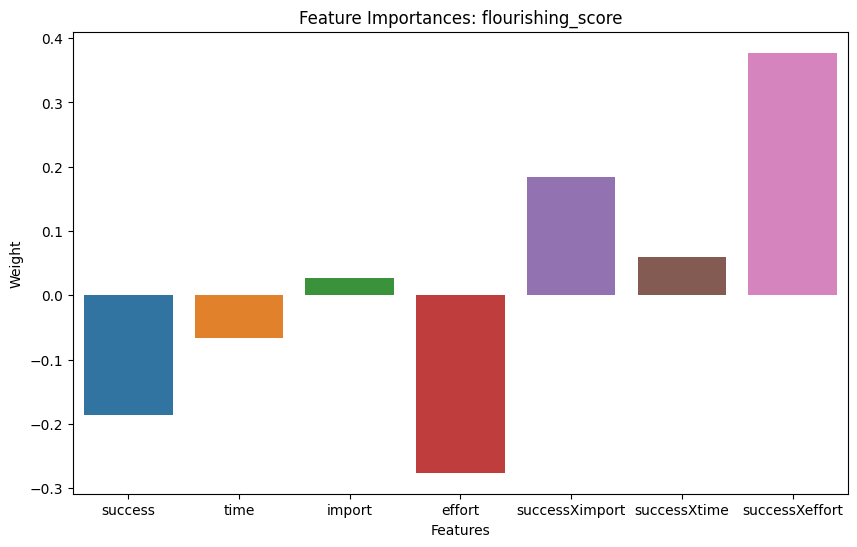

Cross-validated Mean Squared Error: 1.58994857334551


Test Mean Squared Error: 1.484552666126275


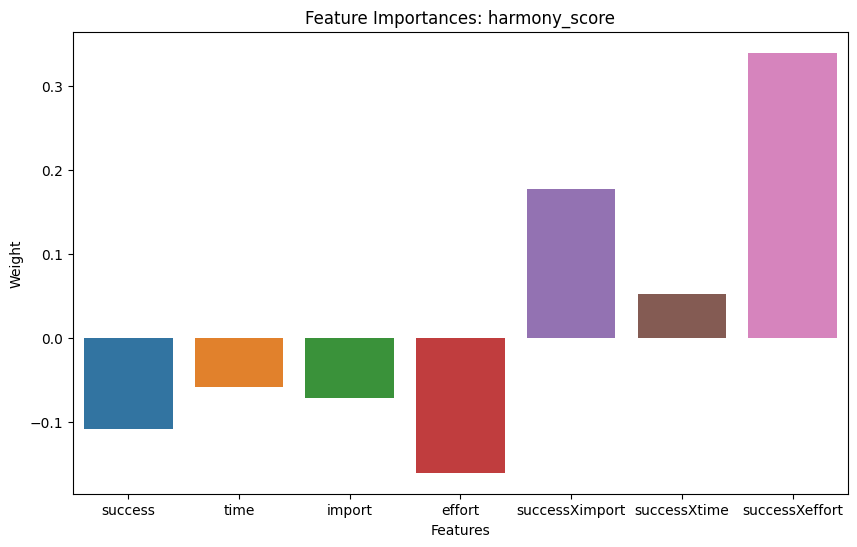

Cross-validated Mean Squared Error: 0.7952134445883585
Test Mean Squared Error: 0.7489395321636637


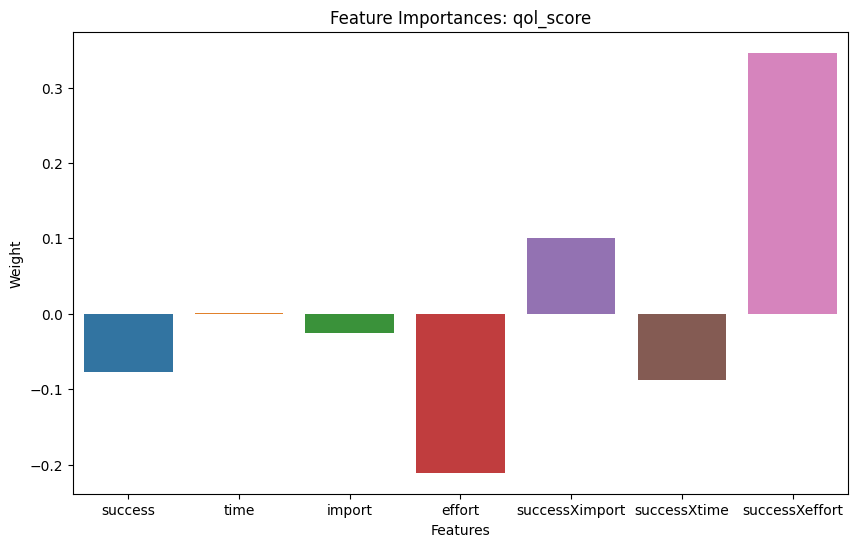

Cross-validated Mean Squared Error: 1.8520054836074666
Test Mean Squared Error: 1.854656550361748


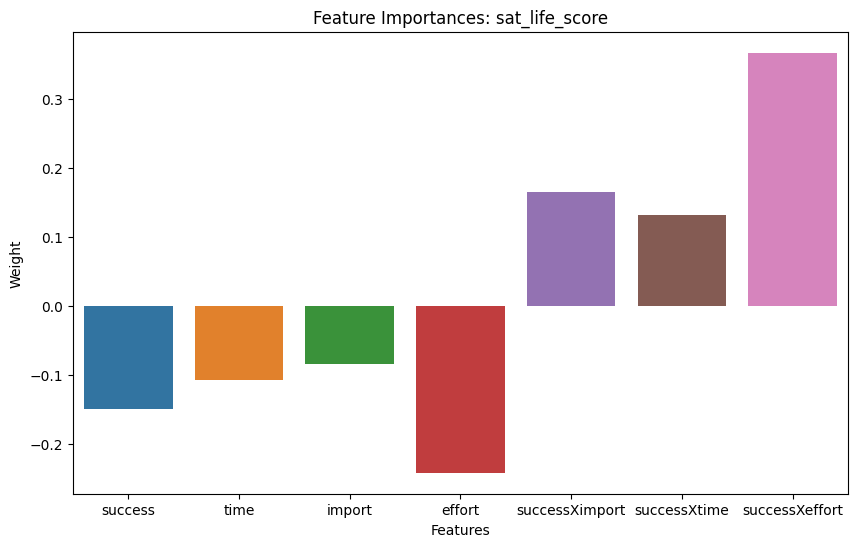

Cross-validated Mean Squared Error: 1.4745022853878726
Test Mean Squared Error: 1.5256355714874787


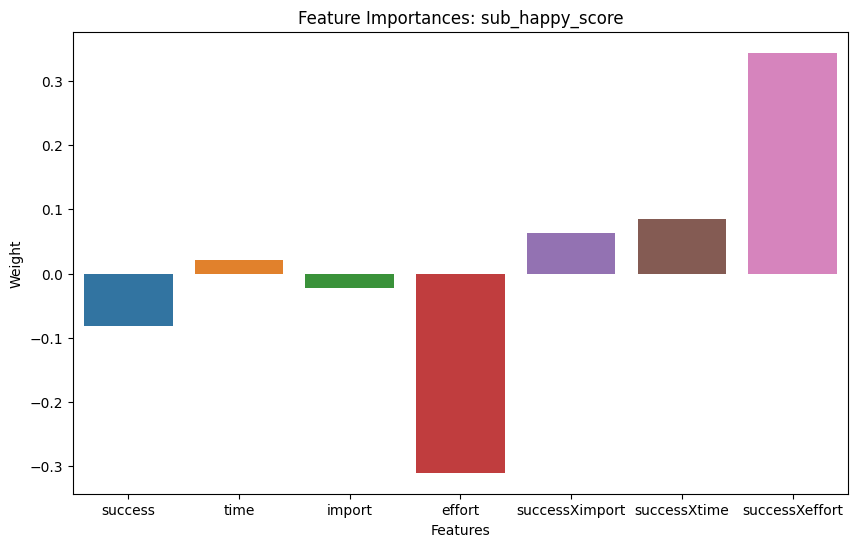

Cross-validated Mean Squared Error: 0.32650845717290766
Test Mean Squared Error: 0.33496426363144566


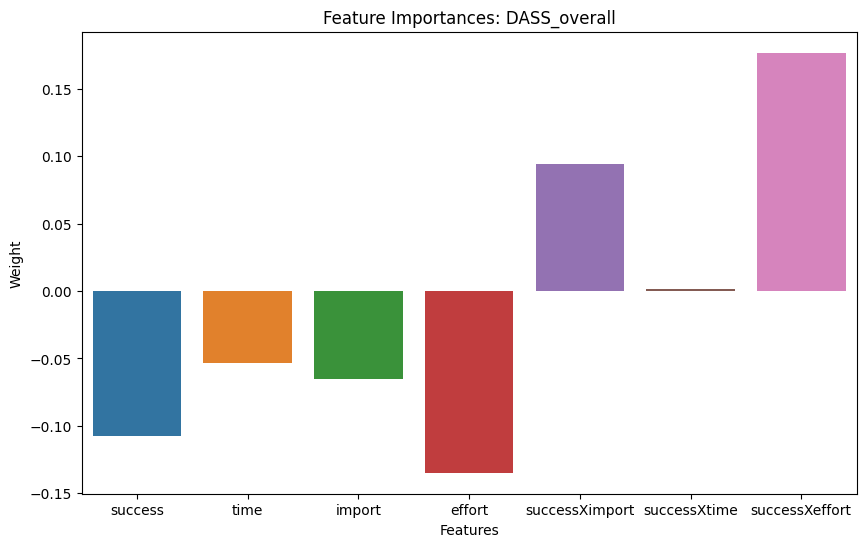

Cross-validated Mean Squared Error: 0.3618891891121594
Test Mean Squared Error: 0.3350296233501258


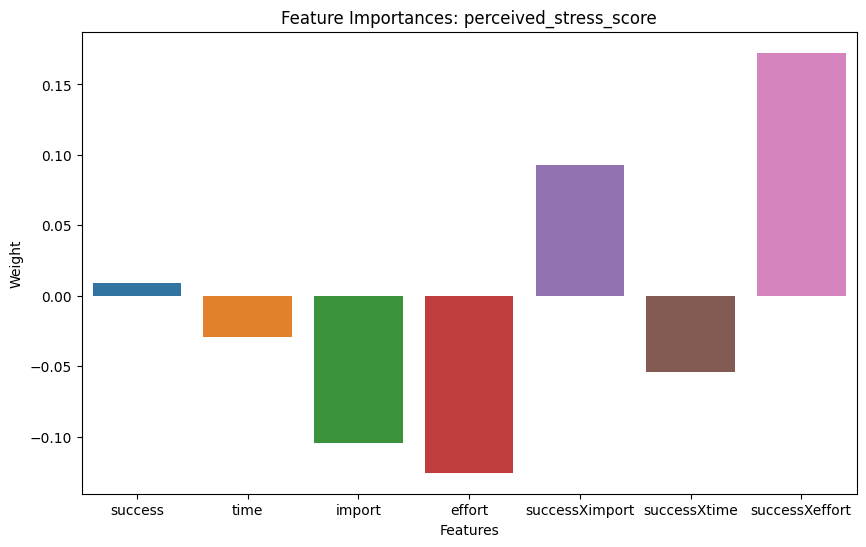

Cross-validated Mean Squared Error: 0.2999155818493153
Test Mean Squared Error: 0.28755238610744227


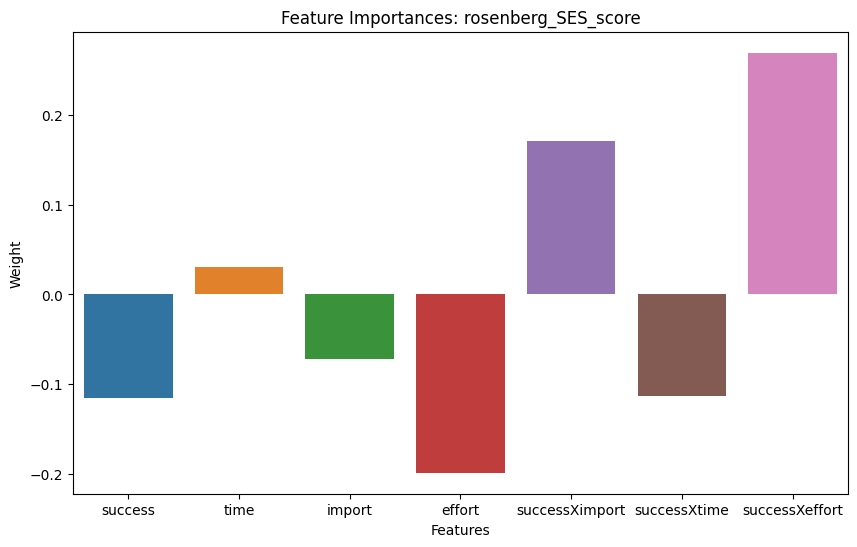

In [24]:
# features
features = ['success', 'time', 'import', 'effort', 'successXimport', 'successXtime', 'successXeffort']

# Create an empty DataFrame with these column names
column_names = ['outcome'] + features + ['train_error', 'test_error'] + ['data_version']
df_coefs = pd.DataFrame(np.empty((len(outcomes), len(column_names))),columns=column_names)

# which data are we using?
data_version = 'Interactions - 7 dimensions'

for outcome in outcomes:
    # select df
    df_temp = df[features + [outcome]]

    # Remove rows with na values
    df_temp = df_temp.dropna()

    # Separate features and target
    X = df_temp[features]
    y = df_temp[outcome]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # # Look at data
    # train_dataset = X_train.copy()
    # train_dataset.insert(0, outcome, y_train)
    # _ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

    # Define a pipeline. We standardize the data first, then apply linear regression
    pipeline = make_pipeline(StandardScaler(), LinearRegression())

    # Define a cross-validation strategy
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    # Use the cross_val_score function to perform cross-validation
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

    # # Print the mean of the cross-validation scores
    print(f'Cross-validated Mean Squared Error: {-cv_results.mean()}')

    # Fit and evaluate the pipeline
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Test Mean Squared Error: {mse}')

    ## Update dataframe
    # get current index
    ix = outcomes.index(outcome)

    # name outcome
    df_coefs.loc[ix, 'outcome'] = outcome

    # add data source
    df_coefs.loc[ix, 'data_version'] = data_version
    
    # Add coefs
    model_coefs = pipeline.named_steps['linearregression'].coef_
    df_coefs.loc[ix, features] = model_coefs

    # Add errors
    df_coefs.loc[ix, 'train_error'] = -cv_results.mean()
    df_coefs.loc[ix, 'test_error'] = mse

    # # Plot actual vs predicted values
    # plt.figure(figsize=(10, 6))
    # sns.scatterplot(x=y_test, y=y_pred)
    # plt.xlabel('Actual Values')
    # plt.ylabel('Predicted Values')
    # plt.title('Actual vs Predicted Values: ' + outcome)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=features, y=pipeline.named_steps['linearregression'].coef_)
    plt.xlabel('Features')
    plt.ylabel('Weight')
    plt.title('Feature Importances: ' + outcome)
    plt.show()

#### Apply to Gap Dimensions

In [25]:
# normed average coefs
normed_coefs = df_coefs[features].mean() / df_coefs.success.mean()
normed_coefs

success           1.000000
time              0.320794
import            0.514557
effort            2.032072
successXimport   -1.283104
successXtime     -0.092860
successXeffort   -2.932012
dtype: float64

In [26]:
# norm features (divide by max)
normed_df = df.copy()
normed_df.success = normed_df.success / 100
normed_df['import'] = normed_df['import'] / 7
normed_df.time = normed_df.time / 7
normed_df.effort = normed_df.effort / 7
normed_df.successXeffort = normed_df.successXeffort / 700
normed_df.successXimport = normed_df.successXimport / 700
normed_df.successXtime = normed_df.successXtime / 700

In [27]:
# apply coefs to features
normed_df[features] = normed_df[features] * normed_coefs

In [28]:
# add column with weighted gap
df['model2_gap'] = 100 - (normed_df[features].sum(axis=1) * 100)

In [29]:
model2_gap = df.groupby(['ParticipantIdentifier', 'onOff'])['model2_gap'].mean().reset_index()
model2_gap.head(3)

ParticipantIdentifier        onOff  model2_gap
0  0151d9f1-1644-4437-805e-02f5e244a690  offBoarding   60.255267
1  0151d9f1-1644-4437-805e-02f5e244a690   onBoarding   86.898342
2  02f48bee-6e86-437c-9394-10ae57dadd14   onBoarding   48.091133

# Test Correlations

In [30]:
# create dataframe of outcomes + grit, bscs and conscientiousness + avg gap
add_cols = [
    'brief_self_control_score',
    'con_hex_score',
    'grit_scale_score',
    'future_time_perspective_score',
    'social_des_score',
    'ambition_score',
    'bsss_overall',
    'secular_measure_work_ethic_score'
    #'need_for_cognition_score',
    'domain_gap'
    ]

df_wide = df[outcomes + add_cols + ['ParticipantIdentifier', 'onOff']].drop_duplicates(subset=['ParticipantIdentifier', 'onOff'], keep='first').reset_index(drop=True)
# add model 1
df_wide = df_wide.merge(model1_gap, how='left', on=['ParticipantIdentifier', 'onOff'])
df_wide = df_wide.merge(model2_gap, how='left', on=['ParticipantIdentifier', 'onOff'])

df_wide.head(3)

flourishing_score  harmony_score  qol_score  sat_life_score  \
0              5.500            3.0     4.6875             3.8   
1              5.375            3.6     4.6250             5.0   
2              5.750            5.4     5.0000             6.0   

   sub_happy_score  DASS_overall  perceived_stress_score  rosenberg_SES_score  \
0              5.5      2.714286                     3.3                  2.4   
1              4.5      2.142857                     3.1                  1.9   
2              6.5      1.000000                     3.0                  1.5   

   brief_self_control_score  con_hex_score  ...  \
0                  2.769231            3.9  ...   
1                  3.769231            3.9  ...   
2                  3.000000            2.8  ...   

   future_time_perspective_score  social_des_score  ambition_score  \
0                            5.5          1.384615             4.4   
1                            5.3          1.307692             4.6   
2                            4.0          1.461538             3.0   

   bsss_overall  need_for_cognition_score  domain_gap  \
0         2.250                  3.354839   24.083333   
1         2.625                  3.612903    3.666667   
2         3.000                  3.000000   32.428571   

                  ParticipantIdentifier        onOff model1_gap  model2_gap  
0  0151d9f1-1644-4437-805e-02f5e244a690  offBoarding  40.219453   60.255267  
1  0151d9f1-1644-4437-805e-02f5e244a690   onBoarding  19.279241   86.898342  
2  02f48bee-6e86-437c-9394-10ae57dadd14   onBoarding  55.149183   48.091133  

[3 rows x 21 columns]

In [31]:
predictors = [
    'brief_self_control_score',
    'con_hex_score',
    'grit_scale_score',
    'future_time_perspective_score',
    'social_des_score',
    'ambition_score',
    'bsss_overall',
    'secular_measure_work_ethic_score',
   # 'need_for_cognition_score',

    'domain_gap',
    'model1_gap',
    'model2_gap'
]

# Create an empty DataFrame with these column names
column_names = ['measure'] + outcomes + ['mean_outcomes']
df_preds = pd.DataFrame(np.empty((len(predictors), len(column_names))),columns=column_names)


In [32]:
# Compute the correlation matrix
corr_matrix = df_wide.drop(['onOff', 'ParticipantIdentifier'], axis=1).corr()

for predictor in predictors:
    print(predictor)
    ## Update dataframe
    # get current index
    ix = predictors.index(predictor)
    # name the row
    df_preds.loc[ix, 'measure'] = predictor
    # To get the average correlation of 'item' with the other items, you can take the mean of the corresponding row (or column) in the correlation matrix
    df_preds.loc[ix, 'flourishing_score':'rosenberg_SES_score'] = abs(corr_matrix.loc[predictor, outcomes])
    # Get avg
    df_preds.loc[ix, 'mean_outcomes'] = abs(corr_matrix.loc[predictor, outcomes]).mean()

brief_self_control_score
con_hex_score
grit_scale_score
future_time_perspective_score
social_des_score
ambition_score
bsss_overall
need_for_cognition_score
domain_gap
model1_gap
model2_gap


In [36]:
df_preds = df_preds.sort_values(by='mean_outcomes', ascending=False)
df_preds

measure  flourishing_score  harmony_score  \
10                     model2_gap           0.497494       0.420344   
0        brief_self_control_score           0.431343       0.398966   
9                      model1_gap           0.439352       0.372982   
8                      domain_gap           0.438245       0.376302   
2                grit_scale_score           0.406222       0.349776   
4                social_des_score           0.331440       0.273659   
3   future_time_perspective_score           0.415464       0.280609   
7        need_for_cognition_score           0.267668       0.195429   
5                  ambition_score           0.328216       0.208580   
1                   con_hex_score           0.277002       0.099210   
6                    bsss_overall           0.053717       0.018733   

    qol_score  sat_life_score  sub_happy_score  DASS_overall  \
10   0.400250        0.446758         0.402423      0.315701   
0    0.274381        0.429514         0.340917      0.399018   
9    0.348478        0.401651         0.358959      0.262334   
8    0.343348        0.389297         0.339876      0.202824   
2    0.298819        0.335744         0.275193      0.257824   
4    0.285493        0.303467         0.340014      0.273156   
3    0.183718        0.236199         0.199459      0.028354   
7    0.168279        0.241345         0.164010      0.099310   
5    0.237550        0.132397         0.127579      0.088249   
1    0.226419        0.116559         0.003917      0.114865   
6    0.092589        0.000287         0.094761      0.164911   

    perceived_stress_score  rosenberg_SES_score  mean_outcomes  
10                0.430121             0.465084       0.422272  
0                 0.481651             0.516976       0.409096  
9                 0.421634             0.400686       0.375759  
8                 0.362083             0.356751       0.351091  
2                 0.326216             0.410042       0.332479  
4                 0.324209             0.343731       0.309396  
3                 0.000018             0.250049       0.199234  
7                 0.171537             0.279822       0.198425  
5                 0.061231             0.259307       0.180389  
1                 0.137373             0.228190       0.150442  
6                 0.126520             0.021732       0.071656

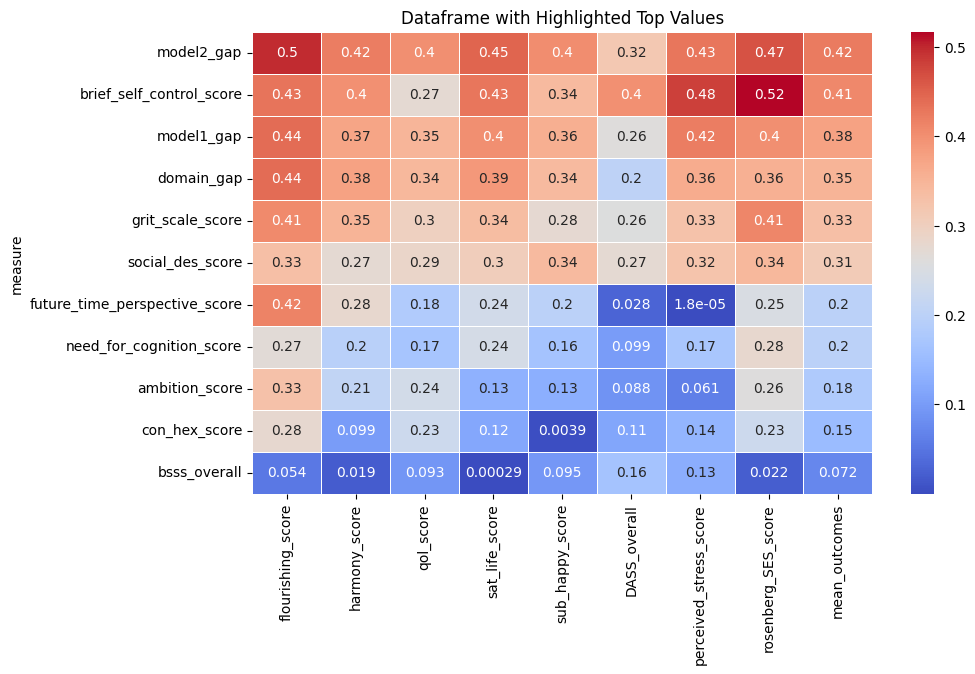

In [38]:
# Identify the max values in each of the Score columns
max_values = df_preds.iloc[:, 1:].max()

# Plot the styled dataframe
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(data=df_preds.set_index('measure'), cmap="coolwarm", annot=True, linewidths=.5, ax=ax)
plt.title("Dataframe with Highlighted Top Values")
plt.yticks(rotation=0)


plt.show()

In [34]:
# See how the correlations look with the gaps scaled by these coefficients...
# Add a version with data grouped by subject
# Test another regression model